In [61]:
# to_save, to_load = False, True
session_file = "./tmp/Misc_ETV_extraction_coshgauss_121121622_A_masking_B.ipynb.pkl"

# # load/save the notebook session
# # https://dill.readthedocs.io/en/latest/
# if True: 
#     import dill
#     dill.load_module(session_file)
#     print(f"Notebook session loaded from  {session_file}")

# if True:  # save the notebook session
#     import dill
#     dill.dump_module(session_file)
#     print(f"Notebook session saved in {session_file}")


Notebook session saved in ./tmp/Misc_ETV_extraction_coshgauss_121121622_A_masking_B.ipynb.pkl


In [1]:
import os
import astropy
import requests
import pandas as pd
import numpy as np
import lightkurve as lk
from scipy.interpolate import interp1d
from astropy.modeling import models, fitting
from astropy.time import Time
import astropy.units as u
import matplotlib.pyplot as plt
import emcee
import sys
import csv
from astropy.timeseries import LombScargle
from os.path import basename, exists

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/utils/')
import filters # Suzanne's functions
import norm

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/ETV')
import etv_functions # Nora's functions

from importlib import reload

%matplotlib inline

In [2]:
from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_base = './etv_out'  # for ETV
lk_download_dir = 'C:/dev/_juypter/PH_TESS_LightCurveViewer/data'

# A command from shell that can be run to notify users, e.g., fitting is finished. Use "echo" if you do not have one
NOTIFY_CMD = "win-notify.bat"

if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir
if hasattr(lk.search, "sr_cache"):   # PR for persistent query result cache
    lk.search.sr_cache.cache_dir = lk_download_dir  # None
    lk.search.sr_cache.expire_seconds = 86400

## Looking for ETVs in TIC 121121622 / KIC 4247791 (component B masked)

- A known doubly-eclipsing  2+2 (EA+EA) candidate.
- https://keplerebs.villanova.edu/overview/?k=4247791 has the values of both sets of eclipses
- See if there is any long-term ETV on pair A (period ~4.10 d ), based on epoch/period from Kepler
- see also: the parameter from the 2012 paper about the SB4 nature
  - https://www.aanda.org/articles/aa/full_html/2012/05/aa18298-11/T1.html


In [24]:
# define the plotting parameters

figsize = (8,4)

In [5]:
# import the data

# choose a TIC ID to analyze
ticid = 121121622

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_path = f"{outfile_base}/tic{ticid}_A_masking_B_etv_primary.csv"
outfile_path_s = f"{outfile_base}/tic{ticid}_A_masking_B_etv_secondary.csv"


# import data using Lightkurve
# sr = lk.search_lightcurve('TIC {}'.format(ticid), author = 'SPOC')
if not "../.." in sys.path:
    sys.path.append("../..")
import lightkurve_ext as lke  # at ../../


sr = lk.search_lightcurve('TIC {}'.format(ticid))  # get long cadence data too
sr = lke.filter_by_priority(sr, author_priority=['SPOC', 'TESS-SPOC', 'QLP'], exptime_priority=['short', 'long', 'fast'])
# sr = sr[sr.exptime != 1800 *u.s]  # exclude 30min cadence data for now (TESS-SPOC, sectors 18, 19, 23 )
# sr = sr[np.isin(sr.author, ['SPOC', 'TESS-SPOC'])]  # exclude QLP to ensure for uniformity in the data
sr = lke._sort_chronologically(sr)  # workaround lightkurve v2.4.2+ change in sort order
with astropy.conf.set_temp("max_lines", -1):
    display(sr)
lcc_tess = sr.download_all()

def use_sap_flux(lc):
    """Helper over select_flux("sap_flux") to ensure flux_err is populated for QLP case"""
    if lc.meta.get("AUTHOR") == "QLP":
        # select_flux("sap_flux") on QLP data will lead to nan flux_err
        # because QLP lc only has err on kspsap_flux / det_flux
        return lc
    else:
        return lc.select_flux("sap_flux")
lc_tess = lcc_tess.stitch(
    # corrector_func=lambda lc: use_sap_flux(lc).normalize()
)
# lc_tess = lc_tess.truncate(None, 1450)  # use data from sectors 2 - 3 for now

lc_tess.time.format = "jd"  # use BJD instead of BTJD to make the result easier to be combined with archival data

search_result_original = lc_tess
search_result = lc_tess

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

SearchResult containing 8 data products.

 #     mission     year author exptime target_name distance  proposal_id 
                                  s                 arcsec               
--- -------------- ---- ------ ------- ----------- -------- -------------
  0 TESS Sector 14 2019   SPOC     120   121121622      0.0       G022062
  1 TESS Sector 40 2021   SPOC     120   121121622      0.0 G04171_G04206
  2 TESS Sector 41 2021   SPOC     120   121121622      0.0 G04171_G04206
  3 TESS Sector 53 2022   SPOC     120   121121622      0.0 G04171_G04206
  4 TESS Sector 54 2022   SPOC     120   121121622      0.0 G04171_G04206
  5 TESS Sector 74 2024    QLP     200   121121622      0.0           N/A
  6 TESS Sector 80 2024   SPOC     120   121121622      0.0        G06057
  7 TESS Sector 81 2024   SPOC     120   121121622      0.0        G06057

C:\pkg\_winNonPortables\miniforge3\envs\my_lk_plus2\Lib\site-packages\lightkurve\collections.py:212: LightkurveWarning: The following columns will be excluded from stitching because the column types are incompatible: {'sap_bkg_err', 'sap_flux', 'sap_bkg'}
  warnings.warn(


139775

In [28]:
Time(3479.89, format="btjd").to_value("jd")

2460479.89

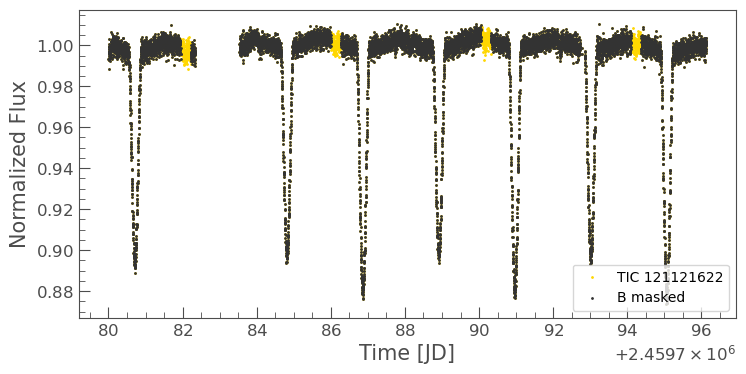

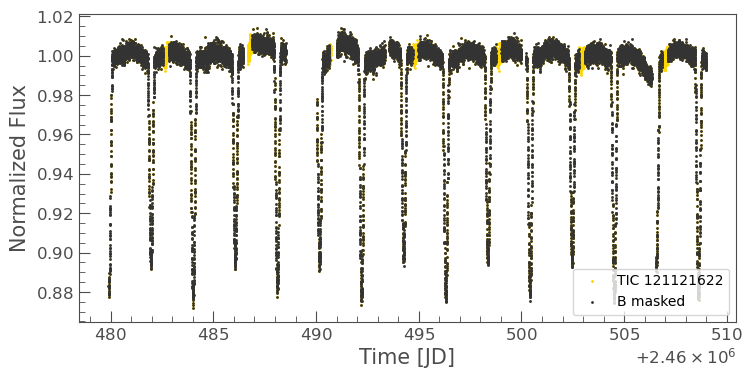

In [35]:

# masking component B, params from https://keplerebs.villanova.edu/overview/?k=4247791
B_period = 4.0497388

B_t0_primary = 54954.796044 + 2400000
B_duration_p = 0.0515 * B_period
B_duration_factor = 1.3  # to be safe, mas out eclipses   

# no secondary 

B_mask_p = lc_tess.create_transit_mask(period=B_period, transit_time=B_t0_primary, duration=B_duration_p * B_duration_factor)
lc_tess_B_masked = lc_tess[~B_mask_p]

# demonstrate that the masking works
for _t, _tspan in [
    (2459780, 30),
    (2460479, 30), # around TESS sector 80
]:
    ax = lc_tess.truncate(_t, _t + _tspan).scatter(c="gold");
    ax = lc_tess_B_masked.truncate(_t, _t + _tspan).scatter(ax=ax, label="B masked");
    ax.legend(loc="lower right");

search_result = lc_tess_B_masked

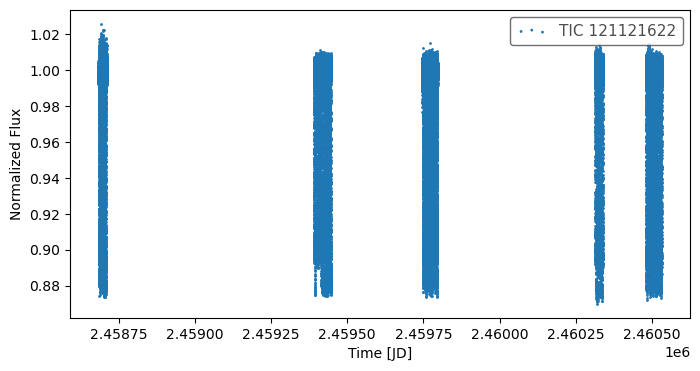

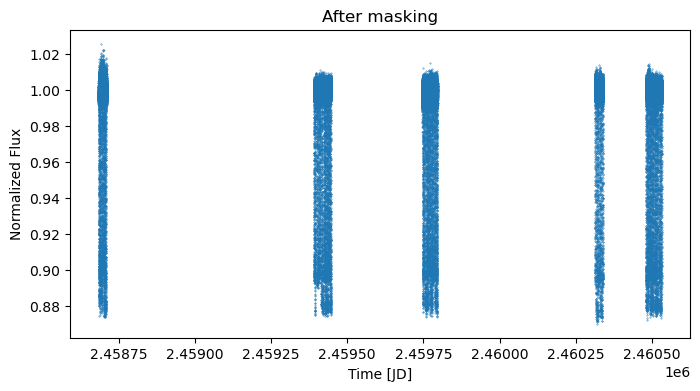

In [36]:
%matplotlib inline
# %matplotlib widget
    
time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

# mask out data you don't like...

fig, ax = plt.subplots(figsize=figsize)
search_result.scatter(ax = ax)

mask = time < 0  #( time > 54950) & (time < 54963)  #  truncate weird spikes at the beginning of Kepler data
# mask = flux < 0.85    # remove occasional outliers
# mask = (
#     ( flux < 0.95 ) | # remove occasional lone outliers
#     # cadences where scattered light effect is prevalent
#     ( (time > 2718)   & (time < 2744) )
# )

time = time[~mask]
flux = flux[~mask]
fluxerr = fluxerr[~mask]

# make sure that therte are no nans!

finite_mask = np.isfinite(time) * np.isfinite(flux) * np.isfinite(fluxerr)

# make a dictionary of the data

data = pd.DataFrame({'time': time[finite_mask], 'flux': flux[finite_mask], 'err': fluxerr[finite_mask]})

ax2 = plt.figure(figsize=figsize).gca()
ax2.scatter(data.time, data.flux, s=0.1);
ax2.set_ylabel(ax.get_ylabel())
ax2.set_xlabel(ax.get_xlabel())
ax2.set_title("After masking");

In [ ]:
do_bls = False

if do_bls:
    if not "../.." in sys.path:
        sys.path.append("../..")
    import lightkurve_ext_pg_runner as lke_pg_runner  # at ../../

    bls_result = lke_pg_runner.run_bls(
        search_result.remove_nans(),
        pg_kwargs=dict(
            minimum_period=1, maximum_period=20,
            frequency_factor=1,
            duration=[3.4957 / 24 * f for f in [0.975, 1, 1.025, 1.05, 1.1, 1.15,]],  # based on observed primary eclipse duration for better fit
        ),
    )
    !$NOTIFY_CMD  "BLS Done"

In [ ]:
do_ls = False

if do_ls:
    if not "../.." in sys.path:
        sys.path.append("../..")
    import lightkurve_ext_pg as lke_pg  # at ../../

    lc = lk.LightCurve(time=Time(time, format="btjd"), flux=flux, flux_err=fluxerr)
    lc.meta["LABEL"] = f"TIC {ticid}"
    pg = lc.to_periodogram(method="lombscargle",
                           # maximum_period=10,
                           # minimum_period=0.4,
                           # ls_method="fastchi2", nterms=2,
                           # oversample_factor=50,  # default: 5
                          )

    pg.show_properties();
    print(pg.period_at_max_power);

    ax = lke_pg.plot_pg_n_mark_max(pg, max_period_factor=10);

    ax = pg.plot(view="frequency");  # frequency view
    ax.set_xlim(pg.frequency_at_max_power.value / 100 , pg.frequency_at_max_power.value * 10);

    ax = pg.plot(view="frequency", unit=u.microhertz, scale="log");

    axs, lcs = lke_pg.plot_lc_with_model(
        lc,
        pg,
        plot_lc=False, plot_model=False, plot_folded_model=True,
        also_return_lcs=True);


In [ ]:
# Visaully compare different candidate period

# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418132651611877).truncate(-0.1, 0.1).scatter(label="BLS period, frequency_factor=10");  # HWHM 0.001571020094789155
# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418147).truncate(-0.1, 0.1).scatter(label="s0001-s0009:TCE1");

### Define epoch, period, duration

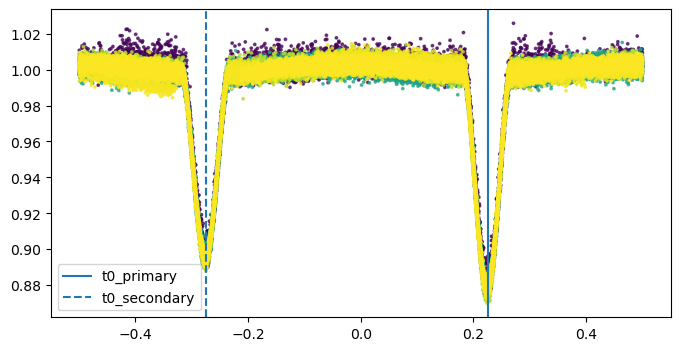

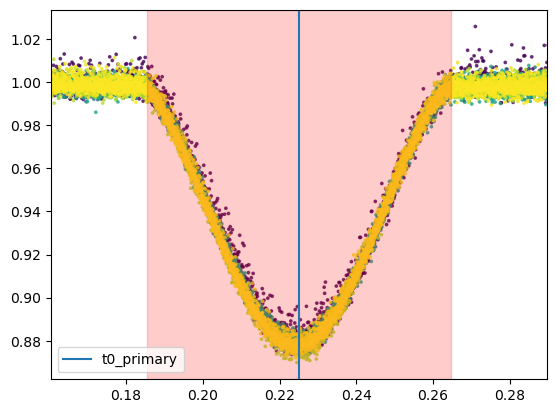

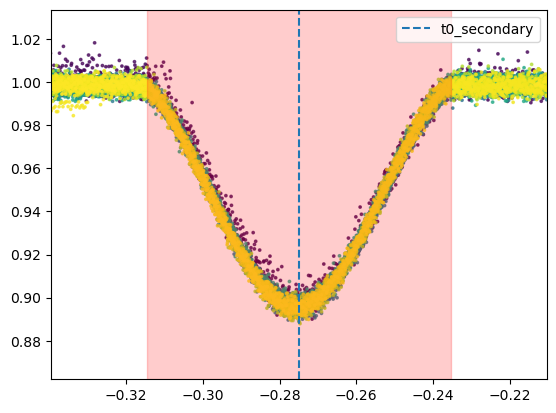

In [37]:
%matplotlib inline
# %matplotlib widget

# define the orbital period and the t0

# Kepler EB values
# dict(epoch=Time(54956.035723 + 2400000, format="jd", scale="tdb").to_value("btjd"), duration_hr=0.0663 * 4.1 * 24, period=4.1008708, label="EB A",


# from: https://keplerebs.villanova.edu/overview/?k=4247791
period = 4.1008708

t0_primary = 54956.035723 + 2400000
t0_secondary = t0_primary + period * 0.5

duration_hr_primary =  7.8  # manual fit rather than Kepler EBs data: period * 0.0663 * 24
duration_hr_secondary = 7.8  # manual fit rather than Kepler EBs data: period * 0.0679 * 24

# convert epoch from BTJD to commonly mjd used here
# t0_primary = Time(t0_primary, format="btjd").to_value("mjd")
# t0_secondary = Time(t0_secondary, format="btjd").to_value("mjd")

# Move t0 to the first dip in the data (some of the subsequent codes, espically fit_each_eclipse(), assumes that)
t0_primary = t0_primary - int((t0_primary - data['time'][0]) / period) * period
if t0_secondary is not None:
    t0_secondary = t0_secondary - int((t0_secondary - data['time'][0]) / period) * period

t0_for_plotting = 0  # keep 0 for plotting purposes
if t0_secondary is not None:
    t0_for_plotting = t0_primary - np.abs(t0_primary - t0_secondary) * 0.45  # use a custom one so that the eclipses are not near the edge (-0.5 or +0.5)

phase = etv_functions.phase_data(data['time'], t0_for_plotting, period)

fig, ax = plt.subplots(figsize = (8,4))

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])

# add the phase to the dataframe
data['phase'] = phase

plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
if t0_secondary is not None:
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.legend()
# plt.ylim(0.535, 0.55)
# plt.xlim(-0.5, 0.1)
plt.show();

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
t1_p, t4_p = etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.5 * duration_hr_primary / 24/ period, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.5 * duration_hr_primary / 24/ period
plt.xlim(t1_p - 0.025, t4_p + 0.025);
plt.axvspan(t1_p, t4_p, color="red", alpha=0.2);plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

if t0_secondary is not None:
    plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
    t1_s, t4_s = etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.5 * duration_hr_secondary / 24/ period, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.5 * duration_hr_secondary / 24/ period
    plt.xlim(t1_s - 0.025, t4_s + 0.025);
    plt.axvspan(t1_s, t4_s, color="red", alpha=0.2);plt.legend();
    plt.legend();
    # plt.ylim(0.975, 1.005);
    plt.show()

### Compare folded plots across sectors

In [ ]:
with plt.style.context(lk.MPLSTYLE):
    fig, axs = plt.subplots(1, len(lcc_tess), figsize=(4 * len(lcc_tess), 3), sharey=True);
    if isinstance(axs, plt.Axes):
        axs = [axs]
    for i, lc in enumerate(lcc_tess):
        lc_f = lc.select_flux("flux").normalize(unit="percent").fold(period=period, epoch_time=t0_primary)
        lc_f = lc_f.truncate(-duration_hr_primary * 2 / 24, duration_hr_primary * 2 / 24)
        ax = lc_f.scatter(ax=axs[i], s=1, label=f"S.{lc_f.sector}");
        ax.legend(loc="lower right");
        if i > 0:
            ax.set_ylabel(None)
            ax.set_xlabel(None)
    fig.suptitle(f"{lc.label}, folded around primary eclipses");
plt.tight_layout();

# ---
with plt.style.context(lk.MPLSTYLE):
    fig, axs = plt.subplots(1, len(lcc_tess), figsize=(4 * len(lcc_tess), 3), sharey=True);
    if isinstance(axs, plt.Axes):
        axs = [axs]
    for i, lc in enumerate(lcc_tess):
        lc_f = lc.select_flux("flux").normalize(unit="percent").fold(period=period, epoch_time=t0_secondary)
        lc_f = lc_f.truncate(-duration_hr_secondary * 2 / 24, duration_hr_secondary * 2 / 24)
        ax = lc_f.scatter(ax=axs[i], s=1, label=f"S.{lc_f.sector}");
        ax.legend(loc="lower right");
        if i > 0:
            ax.set_ylabel(None)
            ax.set_xlabel(None)
    fig.suptitle(f"{lc.label}, folded around secondary eclipses");
plt.tight_layout();

### Detrend (optional)

- detrended flux is in `flux_detrended`, and won't be used in subsequent work by default

In [ ]:
data["flux_original"] = data.flux  # save the original flux 

In [ ]:
# show data to visualize what's changed in each step below
data

In [ ]:
# phase fold the data and create an appoximate binary model (top) and subtract it from the data (bottom)
#_, _ , flux_sub_binary, model, _, _ = etv_functions.trend_removal_interact(period, 0, data['time'], data['flux'], data['time'], data['flux'])

data = etv_functions.trend_removal_interact(period, t0_for_plotting, data)
data

In [ ]:
# if you want to detrend the data run this line!

data = etv_functions.detrend_suz(data, T_dur = 10, plot = True)
data

In [ ]:
# plot the phase folded data here so that you know at what phase you want to cut the data to model 
plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])

plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
if t0_secondary is not None:
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.legend()
# plt.ylim(0.535, 0.55)
# plt.xlim(-0.5, 0.1)
plt.show();

plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
t1_p, t4_p = etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.5 * duration_hr_primary / 24/ period, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.5 * duration_hr_primary / 24/ period 
plt.xlim(t1_p - 0.025, t4_p + 0.025);
plt.axvspan(t1_p, t4_p, color="red", alpha=0.2);plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

if t0_secondary is not None:
    plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
    t1_s, t4_s = etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.5 * duration_hr_secondary / 24/ period, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.5 * duration_hr_secondary / 24/ period 
    plt.xlim(t1_s - 0.025, t4_s + 0.025);
    plt.axvspan(t1_s, t4_s, color="red", alpha=0.2);plt.legend();
    plt.legend();
    # plt.ylim(0.975, 1.005);
    plt.show()

In [ ]:
# # Uncomment to use the detrended flux
# #
# print("Use deterended flux")
# data.flux = data.flux_detrended

### Now that the data is ready we can start 

- generally the clipped LC window is ***smaller*** than the eclipse duration, to avoid the complication of fitting ingress/egress.

In [38]:
# define the midpoints of the primary and secondary eclipses and the window width

# if these don't look central - change them!! the eclipses should be central
midpoint_p =  etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0]  # convet to time in phase
# midpoint_p -= 0.004  # the offset is added back to t0_primary (& secondary above
print('Primary:  ', t0_primary, midpoint_p)

# change depending on the width of the eclipses, default to be slightly larger than the primary eclipse
window_width_p = 0.8 * duration_hr_primary / 24 / period   # it seems to be difficult to bit model the flat bottom and the curves outside, focus on the overall shape for now
# use a shoter duration to avoid fitting the out-of-eclipse LC, which has its own variability that the model is not equipped to hanlde
# window_width_p = 0.095
print("window_width_p (phase):", window_width_p)

data_primary = data[(data['phase'] > midpoint_p - window_width_p / 2) & (data['phase'] < midpoint_p + window_width_p / 2) ]
ph_binned,flux_binned,err_binned = etv_functions.run_binning_phased(data_primary.phase, data_primary.flux, yerr=data_primary.err,nbins=1000)


if t0_secondary is not None:
    midpoint_s =  etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0]
    print('Secondary:', t0_secondary, midpoint_s)

    # the coshgauss model seems problematic, try to use a larger width to give it more shape to fit
    window_width_s = 0.8 * duration_hr_secondary / 24 / period
    # window_width_s = 0.22
    print("window_width_s (phase):", window_width_s)

    data_secondary = data[(data['phase'] > midpoint_s - window_width_s / 2) & (data['phase'] < midpoint_s + window_width_s / 2) ]
    ph_binned_s,flux_binned_s,err_binned_s = etv_functions.run_binning_phased(data_secondary.phase, data_secondary.flux, yerr=data_secondary.err,nbins=1000)


### # you need initial guesses!! The order is :
# alpha0, alpha1, t0, d, Tau - CHANGE THESE TO YOUR OWN INITIAL GUESSES
# median flux, -eclipse depth, t0, related to duration, related to shape (U or V)
# t0 in normalixed phase
start_vals = [1.0, -0.12, midpoint_p, 0.021, 0.95]
start_vals_s = [1.0, -0.104, midpoint_s, 0.021, 0.9]

# -- -- -- -- -- -- -- -- --
# etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *start_vals)
etv_functions.plot_initial_guess_interactive(data_primary, ph_binned, flux_binned, err_binned, "midpoint_p", *start_vals)
if t0_secondary is not None:
    # etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *start_vals_s)
    etv_functions.plot_initial_guess_interactive(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, "midpoint_s", *start_vals_s)

print("Start params for  fitting period with MCMC on df_primary:")
print(f"[{start_vals[0]}, {start_vals[1]}, {t0_primary}, {start_vals[3]}, {start_vals[4]}, {period}],");

Primary:   2458679.6264094 0.22500000002825704
window_width_p (phase): 0.06340116835673049
Secondary: 2458681.6768448 -0.2749999999468
window_width_s (phase): 0.06340116835673049


Output(layout=Layout(padding='1em 0px'), outputs=({'output_type': 'display_data', 'data': {'text/plain': '<Fig…

Output(layout=Layout(padding='1em'), outputs=({'name': 'stdout', 'text': '[1.0, -0.12, midpoint_p, 0.021, 0.95…

Output(layout=Layout(padding='1em 0px'), outputs=({'output_type': 'display_data', 'data': {'text/plain': '<Fig…

Output(layout=Layout(padding='1em'), outputs=({'name': 'stdout', 'text': '[1.0, -0.104, midpoint_s, 0.021, 0.9…

Start params for  fitting period with MCMC on df_primary:
[1.0, -0.12, 2458679.6264094, 0.021, 0.95, 4.1008708],


In [ ]:
if False:
    # Export the data around primary eclipses, for period analysis outside of notebook
    data_primary[["time", "flux", "err"]].to_csv(f"tmp/data_primary_{ticid}.csv", index=False)

In [ ]:
# use MCMC to refine the period

use_mcmc_to_fit_period = False


if use_mcmc_to_fit_period:
    import etv_functions_with_period as etvp

    etv_functions.enable_info_log_for_jupyter()

    # MCMC result
    mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p, fit_params_p_stats = etvp.run_mcmc_initial_fit_p(
        data_primary[:],
        # [0.97, -0.46, t0_primary, 0.030, 1.0, period],  # replace with the initial guess above
        nruns=20, discard=1, # for a sanity test,  to ensure the initial guess is not way off.
        # nruns=2000, discard=600,
        autocorr_time_kwargs=dict(tol=20),  # the emcee defaults tol=50 seems to be too strict for our use case, tol of ~10 - 20 seems to be sufficient
        pool=-2,
        plot_chains=True,
        plot_autocorrelation=True,
        plot=True,
        also_return_stats=True,
    )
    print("mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p]]))
    print("std_p:", fit_params_p_stats["std_p"], "; std_t0:", fit_params_p_stats['std_t0'])
    !$NOTIFY_CMD "Fitting period done."

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 3000/3000 [03:50<00:00, 13.00it/s]


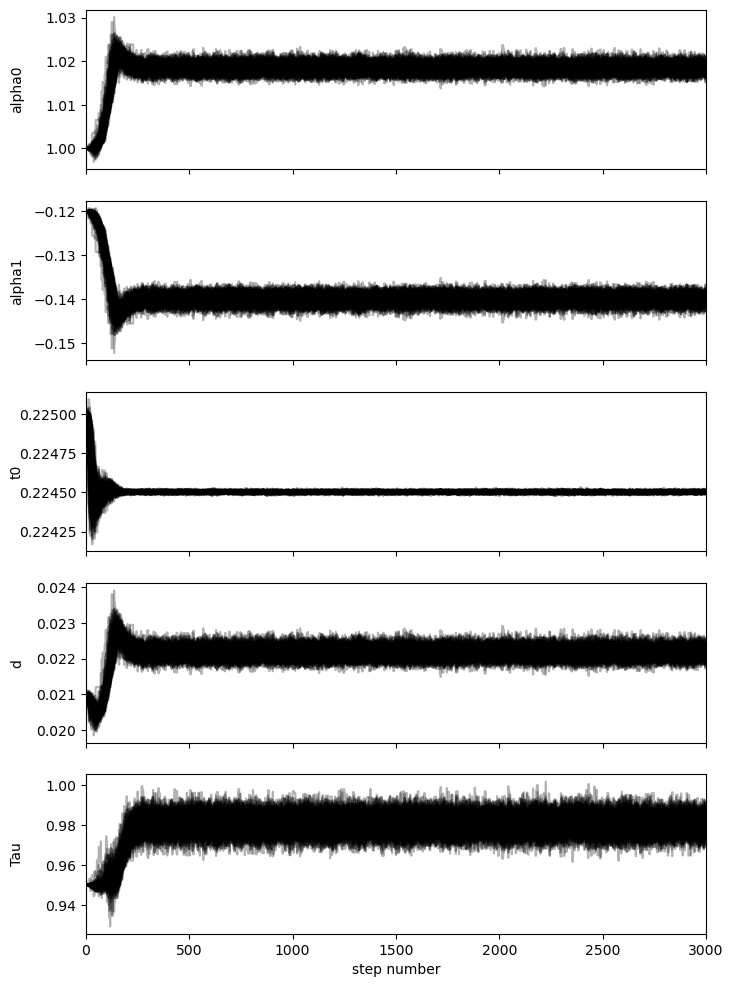

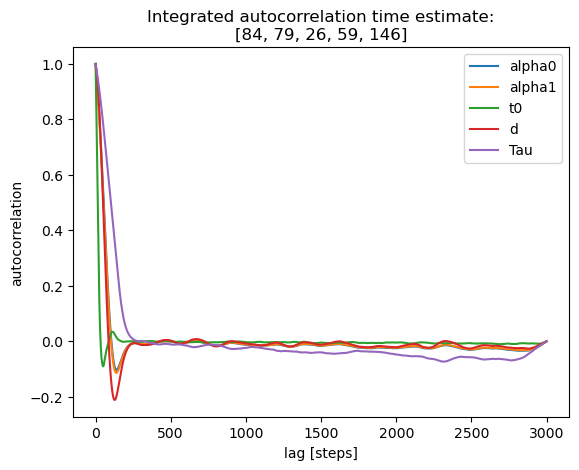

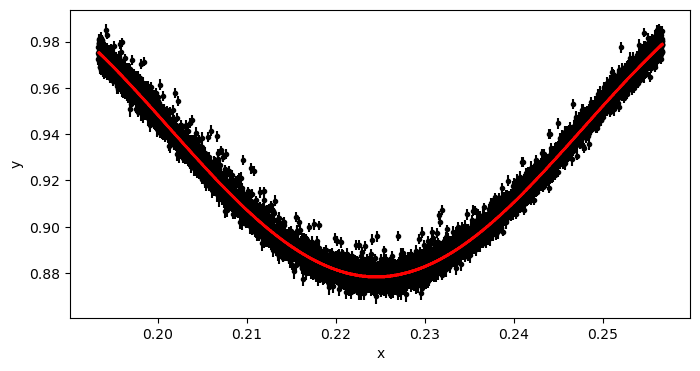

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 3000/3000 [03:53<00:00, 12.83it/s]
The chain is shorter than 20 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/20 = 150;
tau: [ 67.17177136  57.99907882  46.67314613  33.93736856 160.37762086]


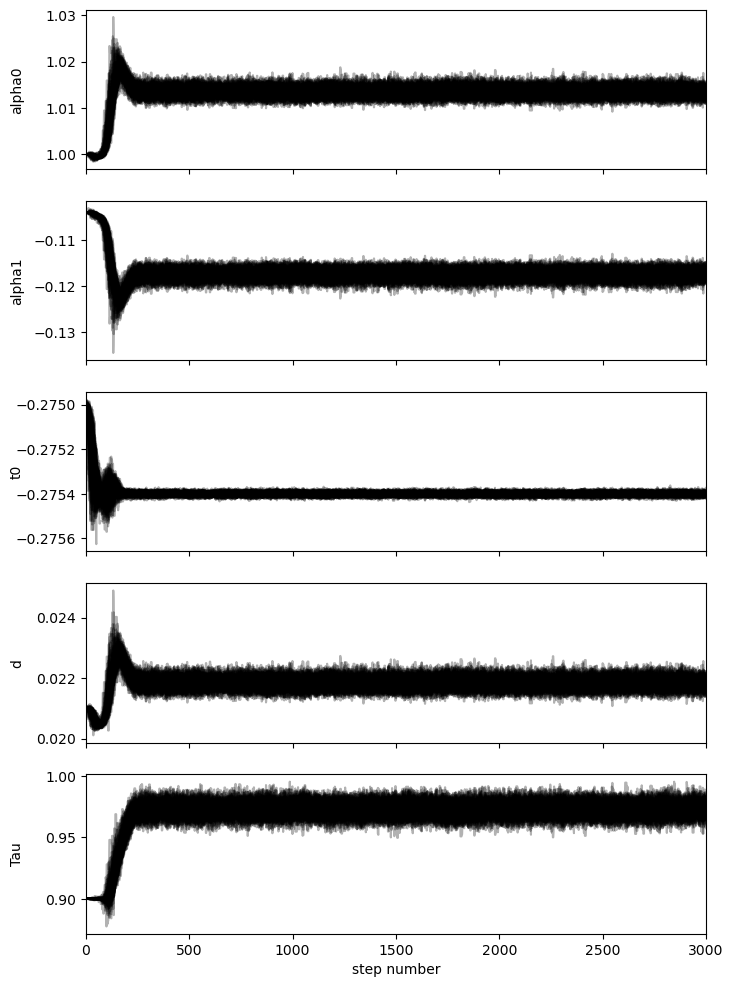

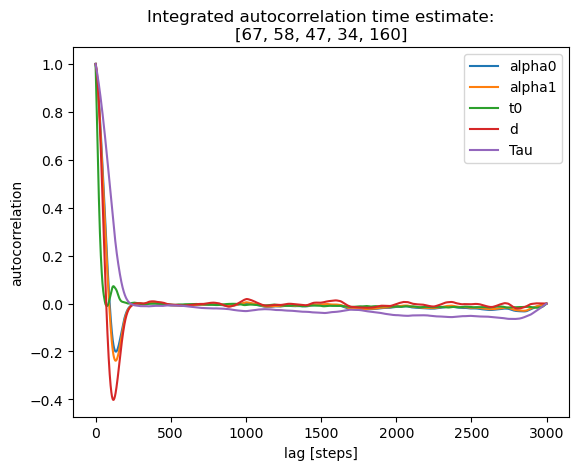

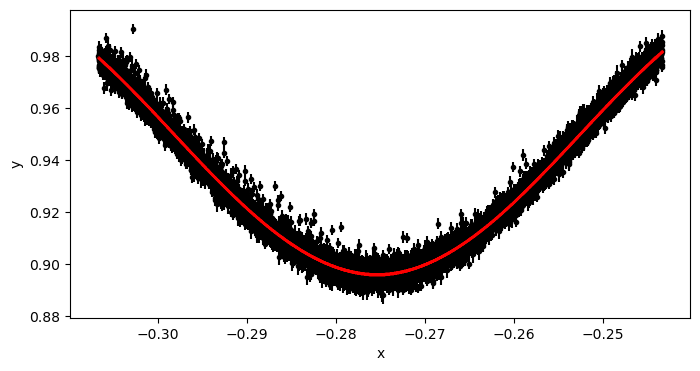

In [13]:
# run the initial model fit using MCMC for the primary and secondary eclipses
run_init_fit = True

if run_init_fit:
    etv_functions.enable_info_log_for_jupyter()
    
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau, fit_params_stats = etv_functions.run_mcmc_initial_fit(data_primary, start_vals, nruns=3000, discard=600, autocorr_time_kwargs=dict(tol=20), pool=-2, plot_chains=True,  plot_autocorrelation=True, plot=True, also_return_stats=True)
    if t0_secondary is not None:
        mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s, fit_params_s_stats = etv_functions.run_mcmc_initial_fit(data_secondary, start_vals_s, nruns=3000, discard=600, autocorr_time_kwargs=dict(tol=20), pool=-2, plot_chains=True,  plot_autocorrelation=True, plot=True, also_return_stats=True)
    !$NOTIFY_CMD "Initial fit done"

Use pre-defined inital model params:


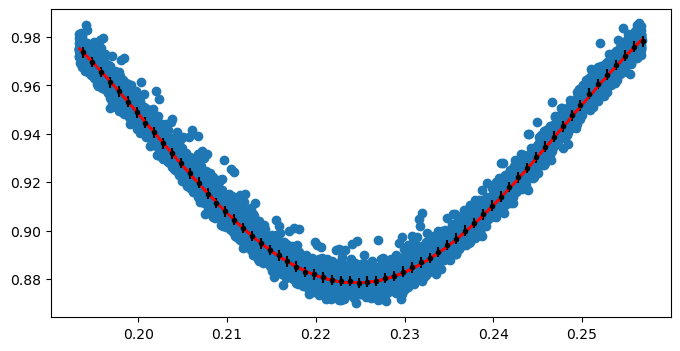

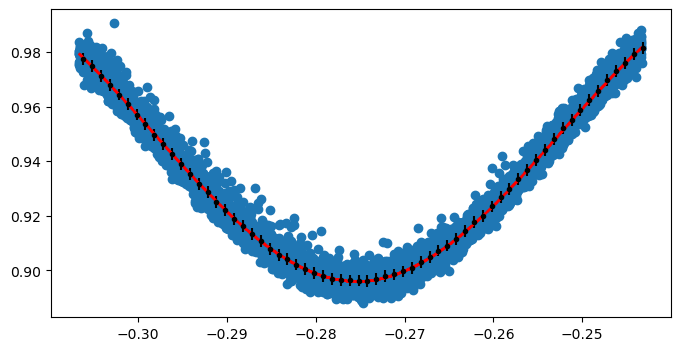

In [39]:
if True:  # use the previoulsy computed value
    print("Use pre-defined inital model params:")
    # initial fit params from TESS data
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.0184216004151734, -0.13990038485502054, 0.22450280397411715, 0.022166538370121114, 0.9806544184922608
    mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.0134706112551553, -0.1173880084138679, -0.27540034885852904, 0.02183132308169211, 0.9729700917783304

    etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *[mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau])
    etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *[mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s])

In [14]:
print("Initial model params:")  # For information, and they can be copied to the cell above for future reuse

print("mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau]]))
if t0_secondary is not None:
    print("mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = " + ", ".join([str(v) for v in [mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s]]))

Initial model params:
mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.0184216004151734, -0.13990038485502054, 0.22450280397411715, 0.022166538370121114, 0.9806544184922608
mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.0134706112551553, -0.1173880084138679, -0.27540034885852904, 0.02183132308169211, 0.9729700917783304


451

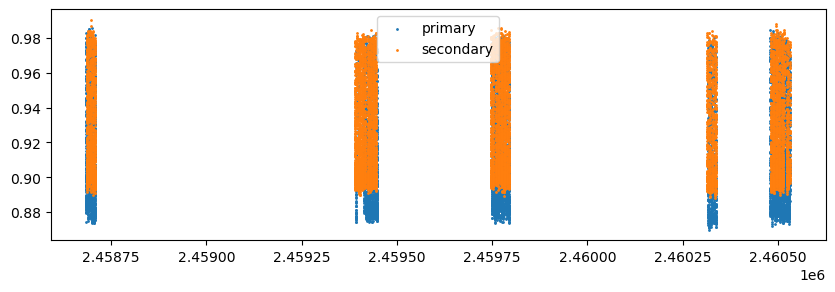

In [40]:
fig = plt.subplots(figsize=(10, 3), sharex=True)
plt.scatter(data_primary.time,data_primary.flux , s = 1, label = 'primary')
if t0_secondary is not None:
    plt.scatter(data_secondary.time,data_secondary.flux , s = 1, label = 'secondary')
plt.legend()

# calculate the number of transits there are within the data
n_transits = int((max(data_primary.time) - min(data_primary.time)) / period)
n_transits

2458679.6264094 4.1008708 2458679.6264094


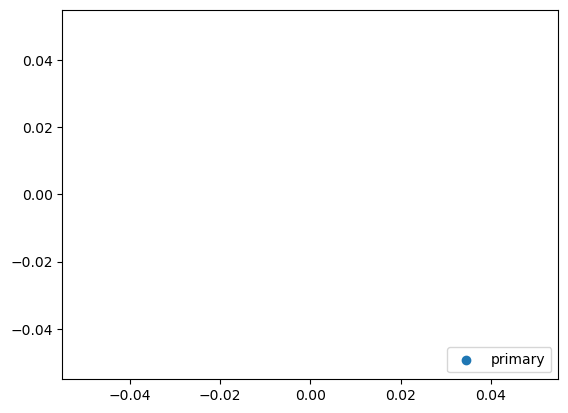

2458679.6264094 4.1008708 2458683.7272802


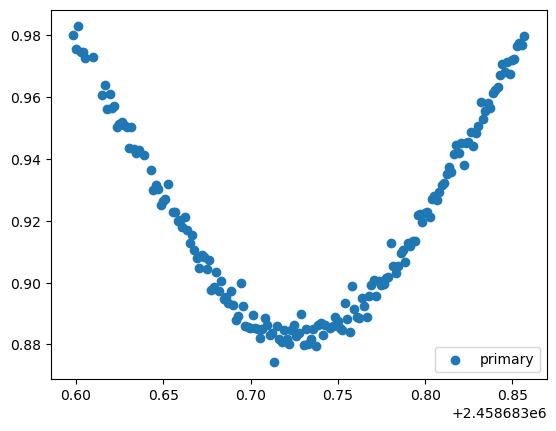

2458679.6264094 4.1008708 2458687.8281509997


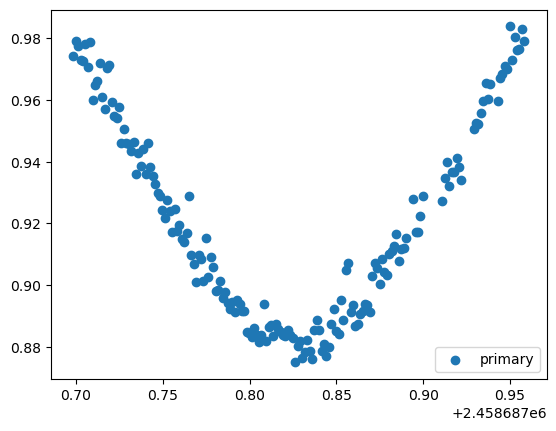

2458679.6264094 4.1008708 2460516.8165277997


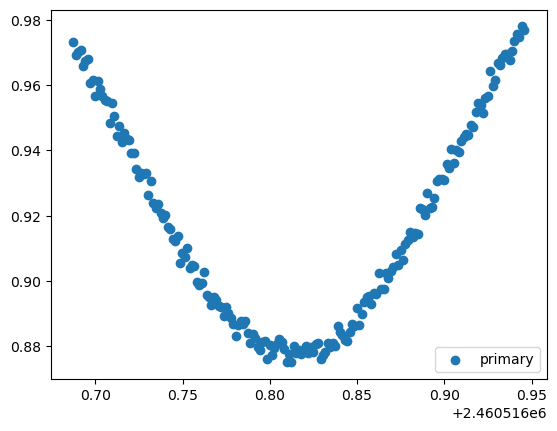

2458679.6264094 4.1008708 2460520.9173986


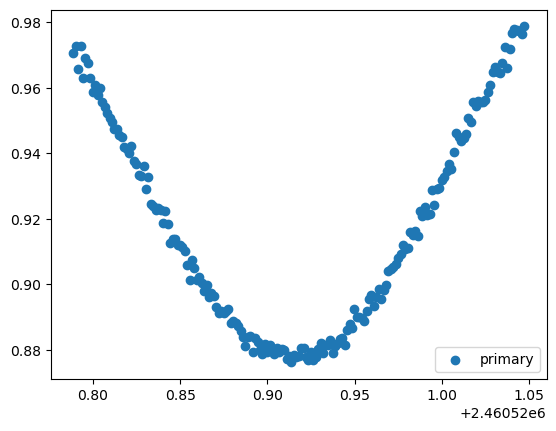

2458679.6264094 4.1008708 2460525.0182693996


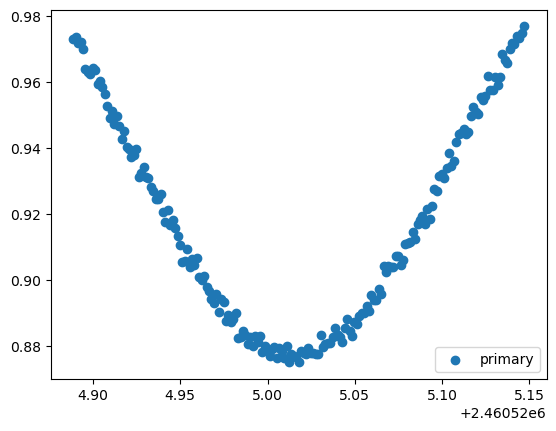

2458681.6768448 4.1008708 2458681.6768448


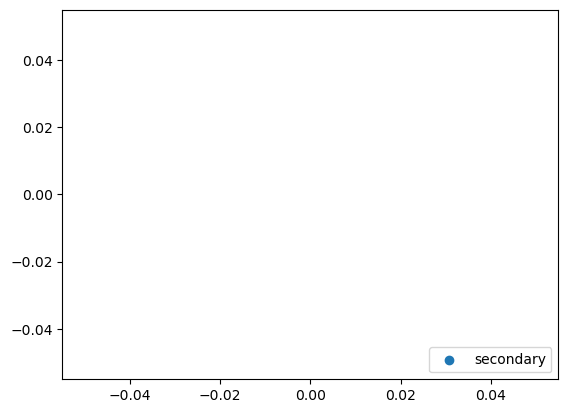

2458681.6768448 4.1008708 2458685.7777156


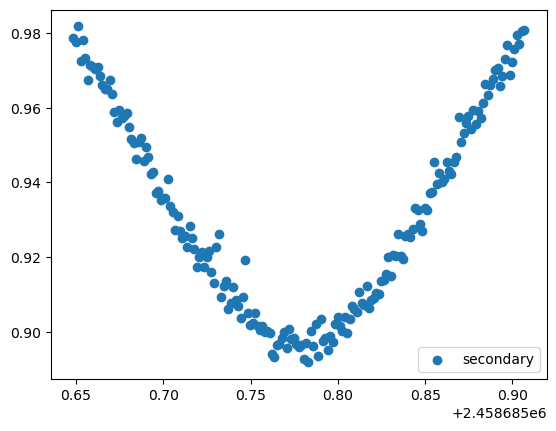

2458681.6768448 4.1008708 2458689.8785864


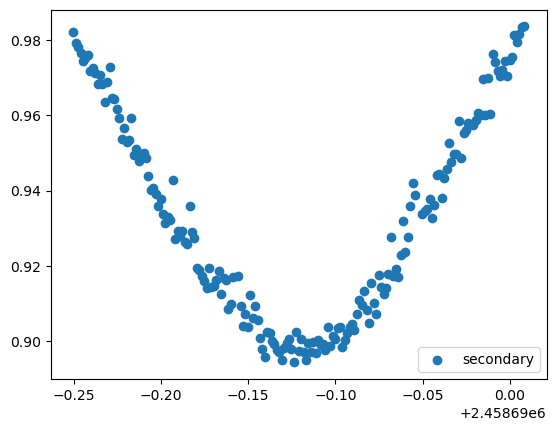

2458681.6768448 4.1008708 2460518.8669632


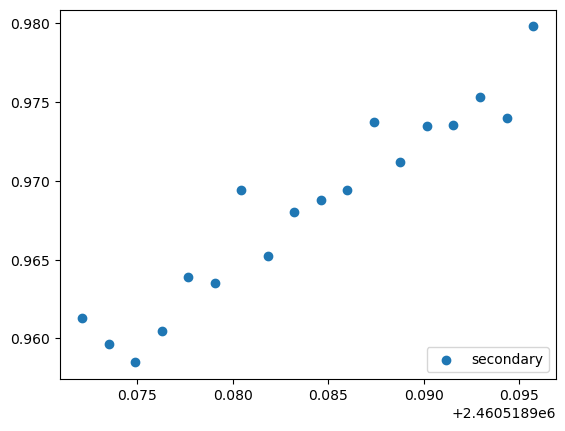

2458681.6768448 4.1008708 2460522.967834


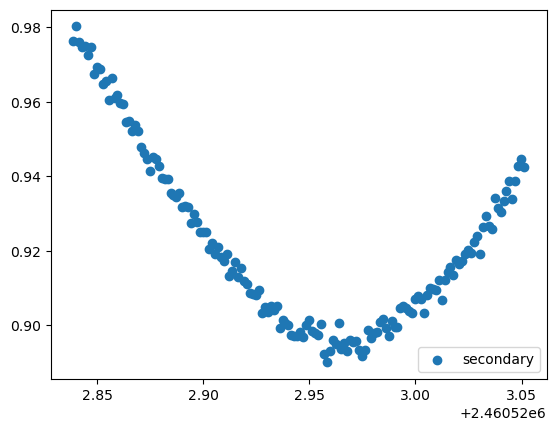

2458681.6768448 4.1008708 2460527.0687047997


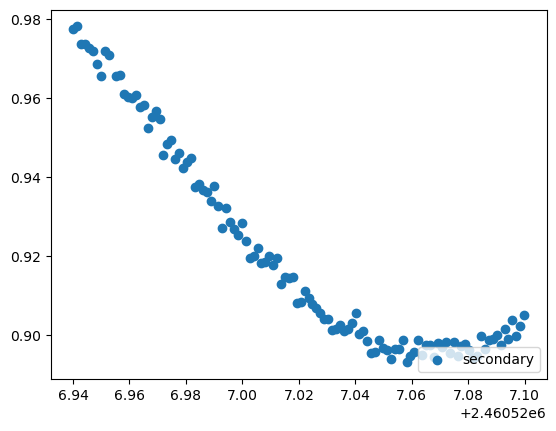

In [41]:
tr_index = range(0,n_transits)

for i in np.concatenate( (tr_index[0:3], tr_index[-3:]) ): 
    transit_time = t0_primary+(period*i)
    x = np.array(data_primary.time)
    y = np.array(data_primary.flux)
    yerr = np.array(data_primary.err)

    print (t0_primary, period, transit_time)

    mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period)))

    x = np.array(x[mask])
    y = np.array(y[mask])
    yerr = np.array(yerr[mask])
    fig, ax = plt.subplots()
    plt.scatter(x,y, label="primary")
    plt.legend(loc="lower right")
    plt.show()


if t0_secondary is not None:
    for i in np.concatenate( (tr_index[0:3], tr_index[-3:]) ): 
        transit_time = t0_secondary+(period*i)
        x = np.array(data_secondary.time)
        y = np.array(data_secondary.flux)
        yerr = np.array(data_secondary.err)

        print (t0_secondary, period, transit_time)

        mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period)))

        x = np.array(x[mask])
        y = np.array(y[mask])
        yerr = np.array(yerr[mask])
        fig, ax = plt.subplots()
        plt.scatter(x,y, label="secondary")
        plt.legend(loc="lower right")
        plt.show()

### Fit individual eclipses

In [42]:
# Provide a warning if the expected number of data points per clipped LC is smaller than the default minimum `min_number_data` (20)
longest_cadence = np.max(sr.exptime)
est_number_data_primary   = int(window_width_p  * period * 24 / longest_cadence.to(u.hr).value)
print(f"Expected num of data points of a clipped LC in longest cadence ({longest_cadence}) for primary: {est_number_data_primary}")
if est_number_data_primary < 20:
    display(HTML("<span style='background-color: rgba(255, 0, 0, 0.7); padding-left: 1ch; padding-right: 1ch;'>WARN:</span> num of data points for a clipped LC (primary) < 20"))

if t0_secondary is not None:
    est_number_data_secondary = int(window_width_s  * period * 24 / longest_cadence.to(u.hr).value)
    print(f"Expected num of data points of a clipped LC in longest cadence ({longest_cadence}) for secondary:  {est_number_data_secondary}")
    if est_number_data_secondary < 20:
        display(HTML("<span style='background-color: rgba(255, 0, 0, 0.7); padding-left: 1ch; padding-right: 1ch;'>WARN:</span> num of data points for a clipped LC (secondary) < 20"))

Expected num of data points of a clipped LC in longest cadence (200.0 s) for primary: 112
Expected num of data points of a clipped LC in longest cadence (200.0 s) for secondary:  112


Fitting individual primary eclipses...
Existing manifest file found, will skip previously processed LCs and append to end of manifest file
Number 1 has already been completed -- skip
2458687.8281509997 1.0184216004151734 -0.13990038485502054 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 335.62it/s]


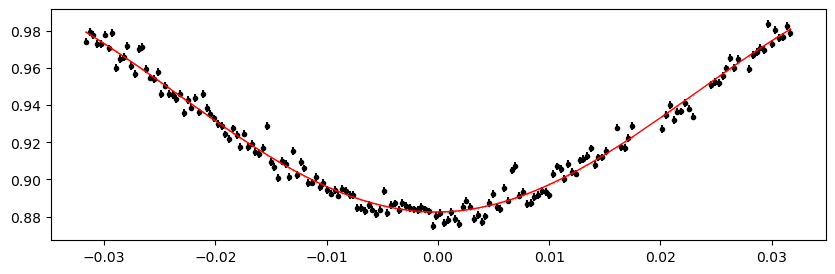

2458691.9290218 1.0184216004151734 -0.13990038485502054 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 333.66it/s]


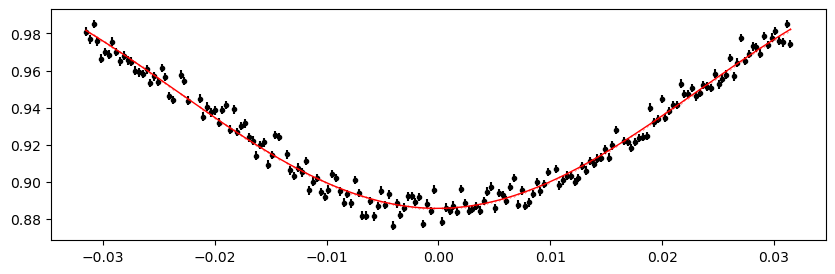

2458696.0298925997 1.0184216004151734 -0.13990038485502054 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 338.62it/s]


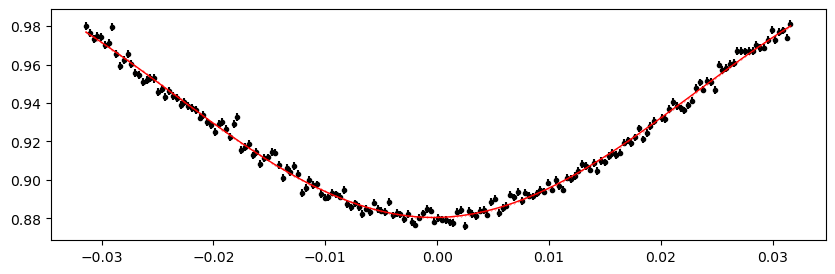

2458700.1307634 1.0184216004151734 -0.13990038485502054 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 344.32it/s]


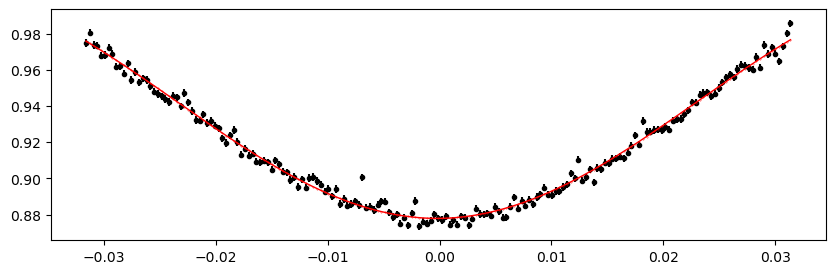

2458704.2316341996 1.0184216004151734 -0.13990038485502054 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 340.72it/s]


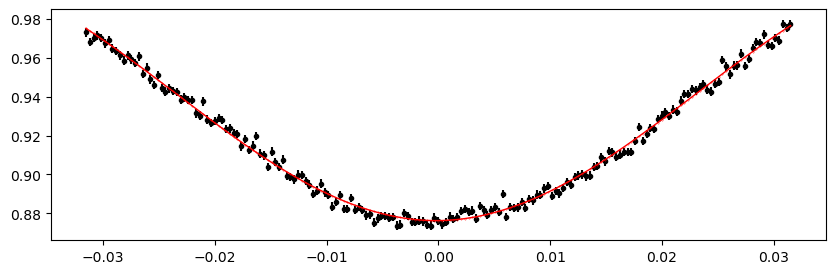

2458708.332505 1.0184216004151734 -0.13990038485502054 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 322.81it/s]


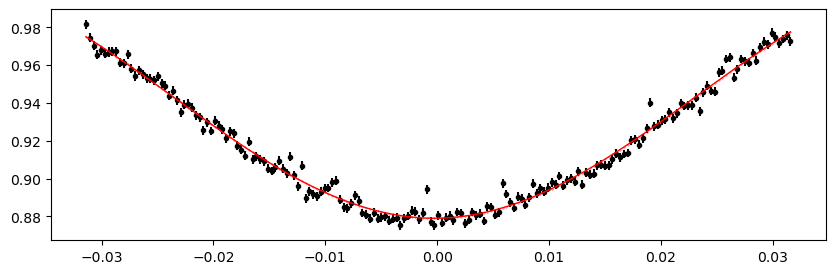

2459393.1779286 1.0184216004151734 -0.13990038485502054 0


100%|██████████████████████████████████████████████████████| 10000/10000 [2:12:32<00:00,  1.26it/s]


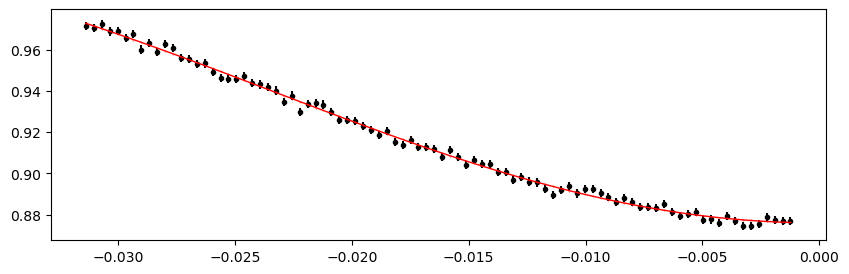

Time 2459397.2787993997 does not have enough data points: 53
Time 2459401.3796702 does not have enough data points: 17
Time 2459405.4805409997 does not have enough data points: 12
Time 2459409.5814118 does not have enough data points: 48
2459413.6822825996 1.0184216004151734 -0.13990038485502054 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 363.10it/s]


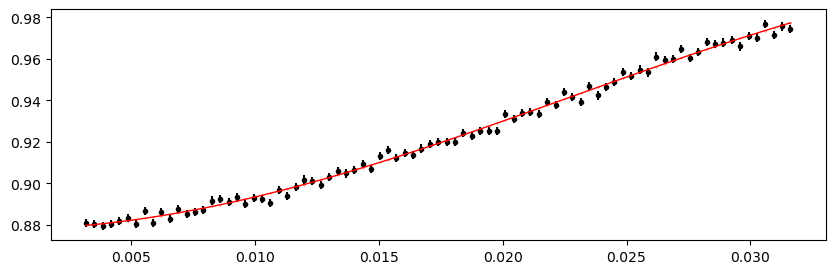

2459417.7831534 1.0184216004151734 -0.13990038485502054 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 361.76it/s]


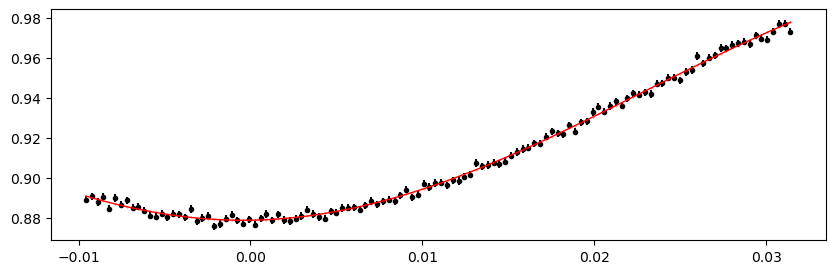

2459421.8840241996 1.0184216004151734 -0.13990038485502054 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 340.36it/s]


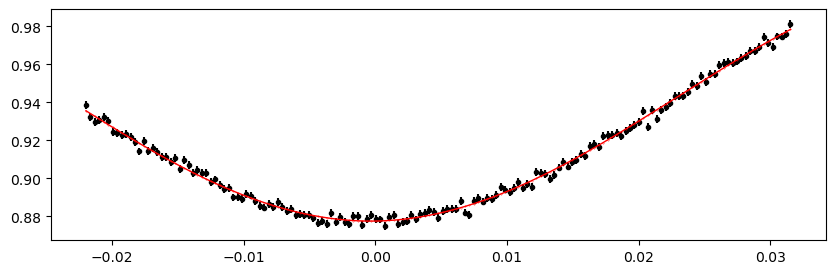

2459425.984895 1.0184216004151734 -0.13990038485502054 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 324.50it/s]


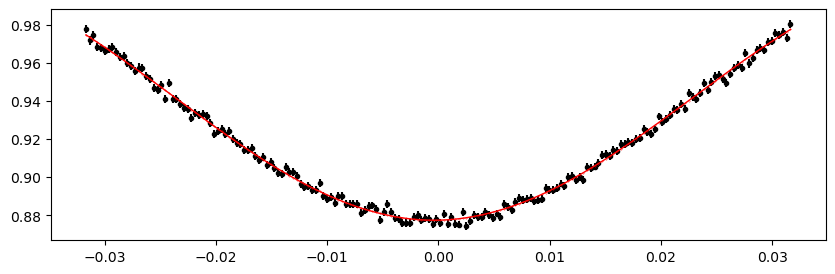

2459430.0857658 1.0184216004151734 -0.13990038485502054 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 324.05it/s]


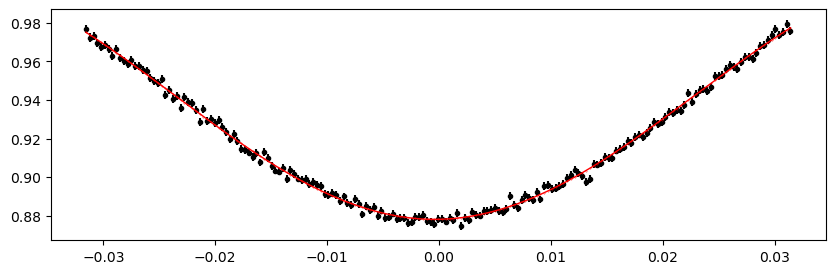

2459434.1866365997 1.0184216004151734 -0.13990038485502054 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 328.75it/s]


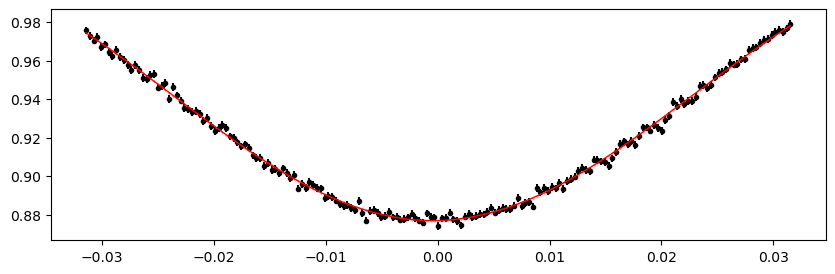

2459438.2875074 1.0184216004151734 -0.13990038485502054 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 325.97it/s]


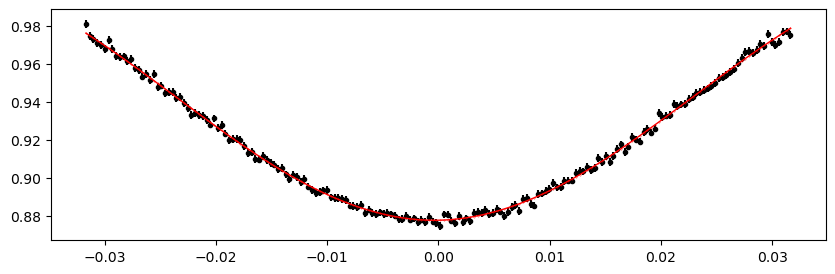

2459442.3883781997 1.0184216004151734 -0.13990038485502054 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 325.10it/s]


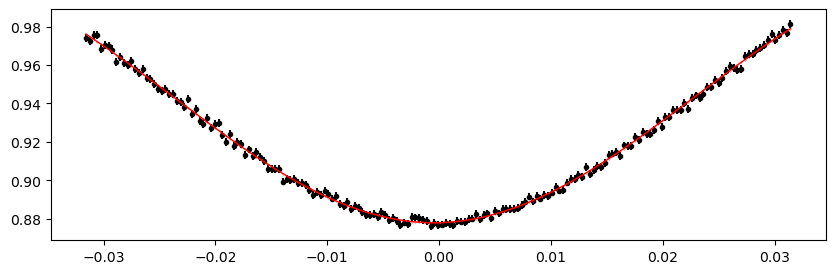

2459446.489249 1.0184216004151734 -0.13990038485502054 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 331.17it/s]


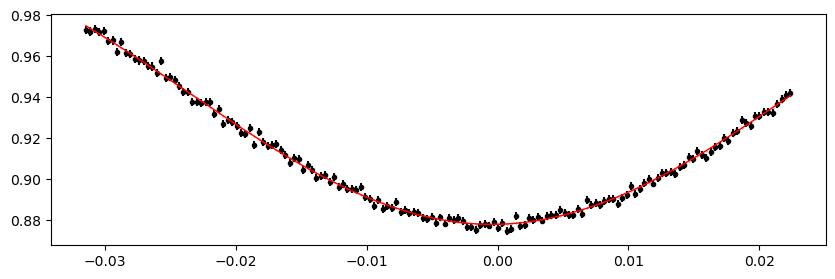

2459749.9536881996 1.0184216004151734 -0.13990038485502054 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 328.76it/s]


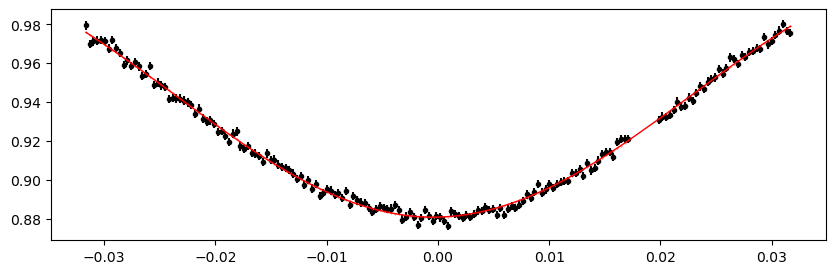

2459754.054559 1.0184216004151734 -0.13990038485502054 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 332.86it/s]


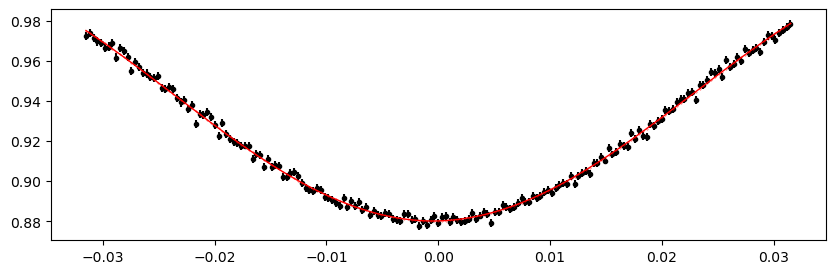

2459758.1554297996 1.0184216004151734 -0.13990038485502054 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 327.77it/s]


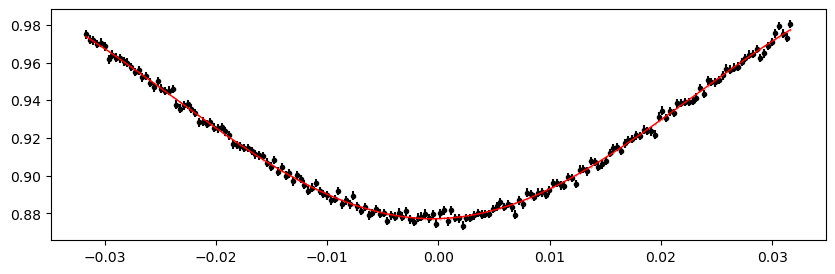

2459762.2563006 1.0184216004151734 -0.13990038485502054 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 335.39it/s]


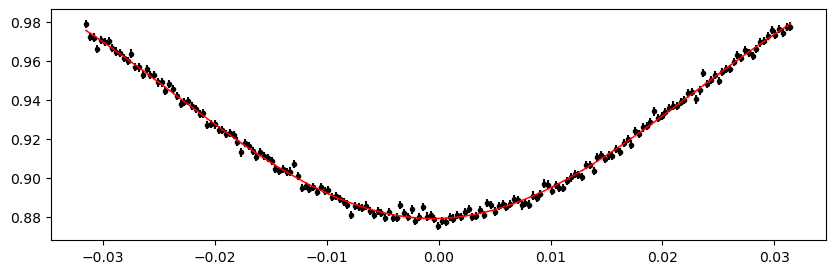

2459766.3571714 1.0184216004151734 -0.13990038485502054 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 334.72it/s]


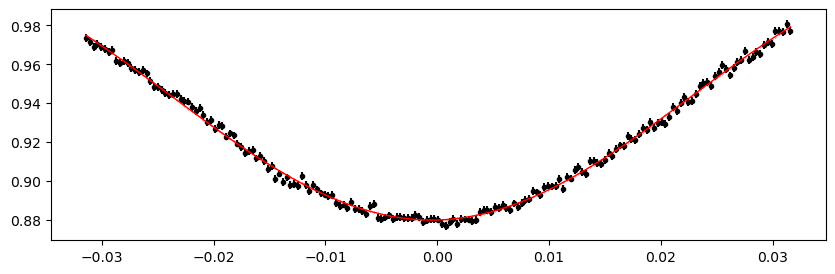

2459770.4580421997 1.0184216004151734 -0.13990038485502054 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 336.54it/s]


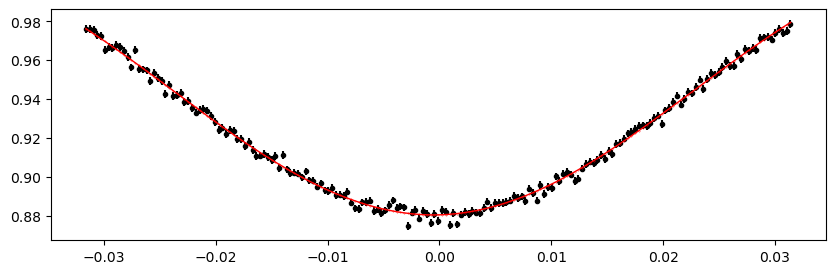

2459774.558913 1.0184216004151734 -0.13990038485502054 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 333.35it/s]


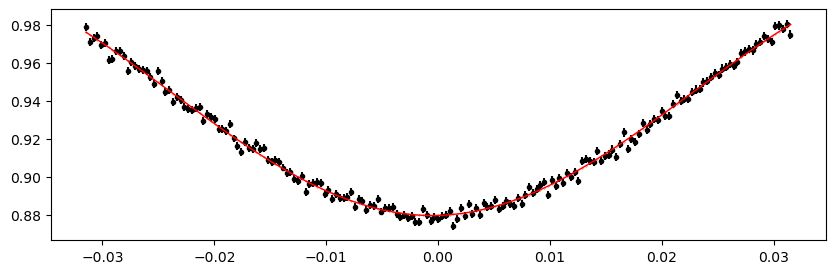

2459778.6597837997 1.0184216004151734 -0.13990038485502054 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 335.07it/s]


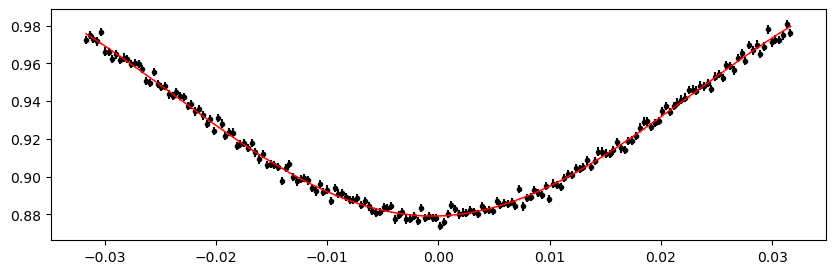

2459786.8615253996 1.0184216004151734 -0.13990038485502054 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 330.75it/s]


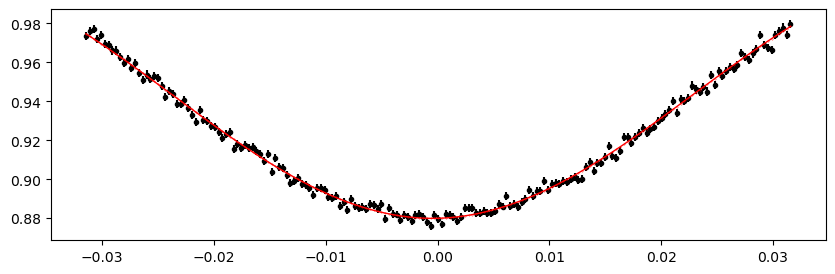

2459790.9623962 1.0184216004151734 -0.13990038485502054 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 334.80it/s]


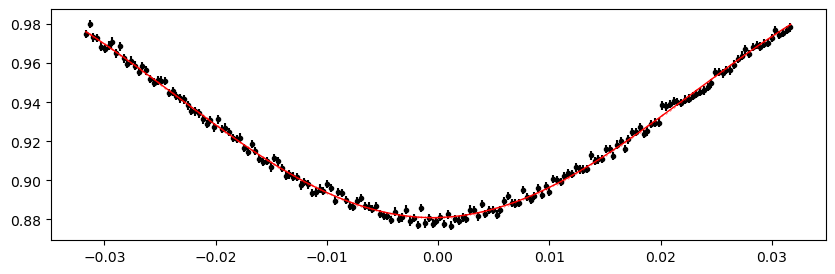

2459795.063267 1.0184216004151734 -0.13990038485502054 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 335.21it/s]


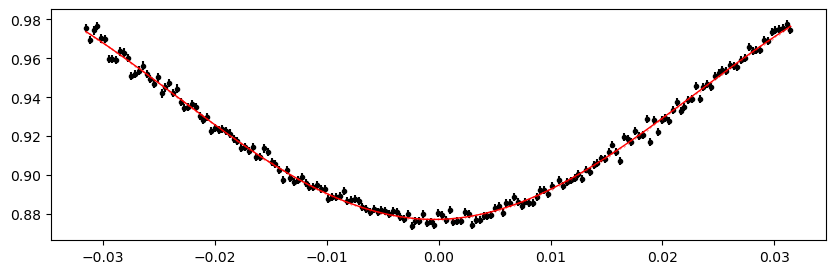

2460315.8738586 1.0184216004151734 -0.13990038485502054 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 375.54it/s]


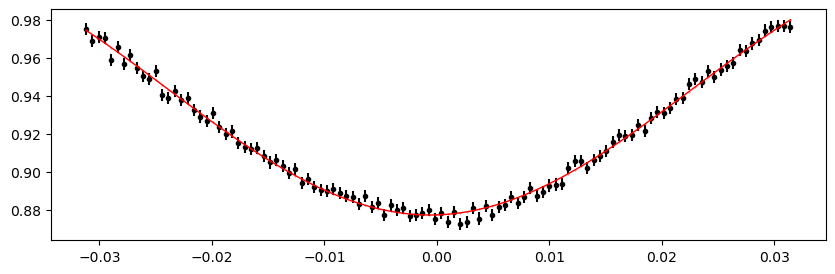

2460319.9747293997 1.0184216004151734 -0.13990038485502054 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 372.68it/s]


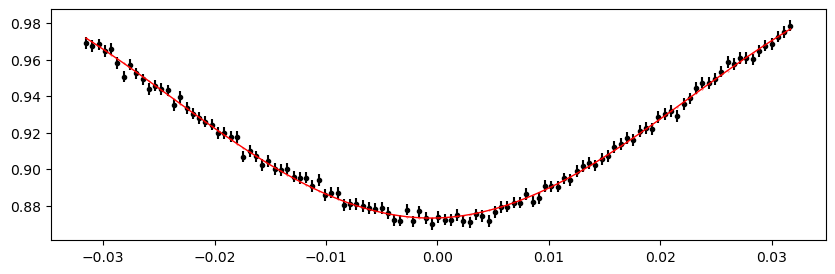

2460324.0756002 1.0184216004151734 -0.13990038485502054 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 369.15it/s]


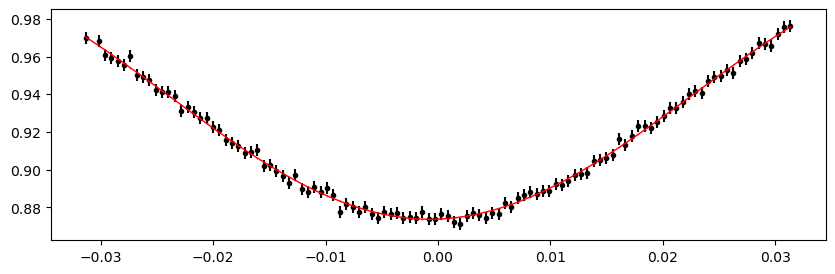

2460328.1764709996 1.0184216004151734 -0.13990038485502054 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 376.53it/s]


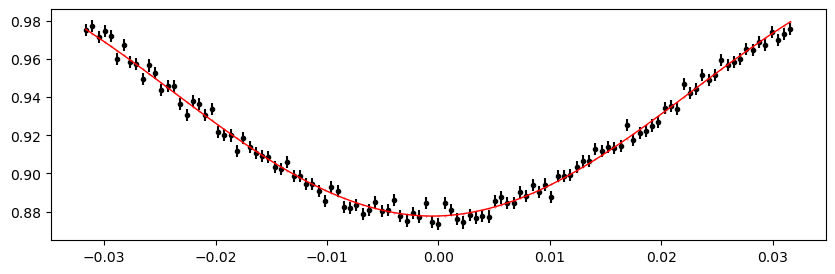

2460332.2773418 1.0184216004151734 -0.13990038485502054 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 379.30it/s]


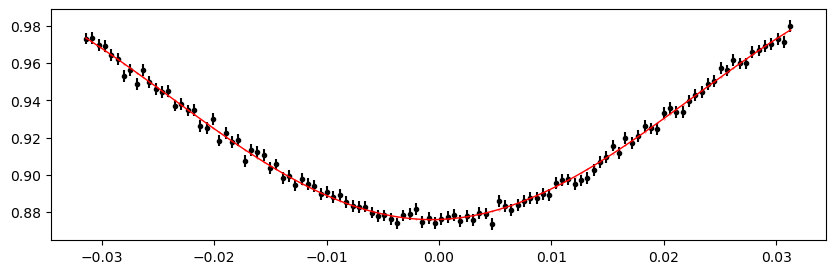

2460336.3782126 1.0184216004151734 -0.13990038485502054 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 376.10it/s]


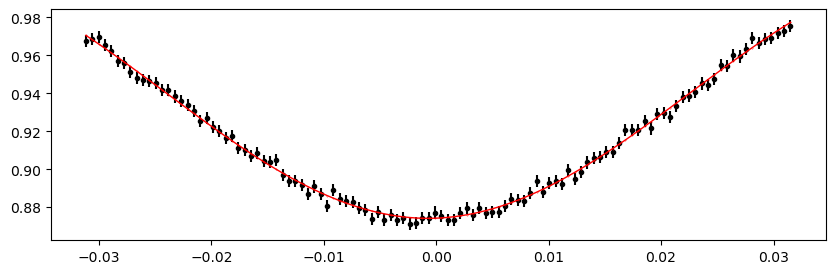

2460479.9086905997 1.0184216004151734 -0.13990038485502054 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 376.86it/s]


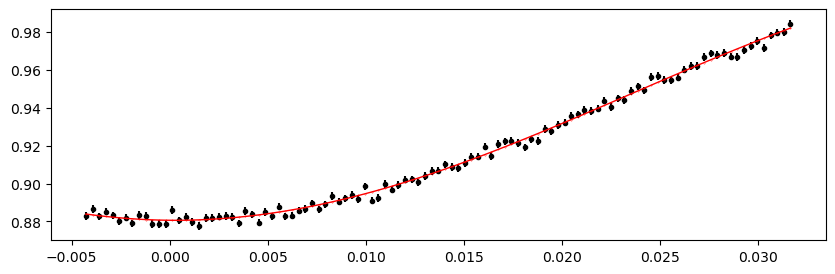

2460484.0095614 1.0184216004151734 -0.13990038485502054 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 346.46it/s]


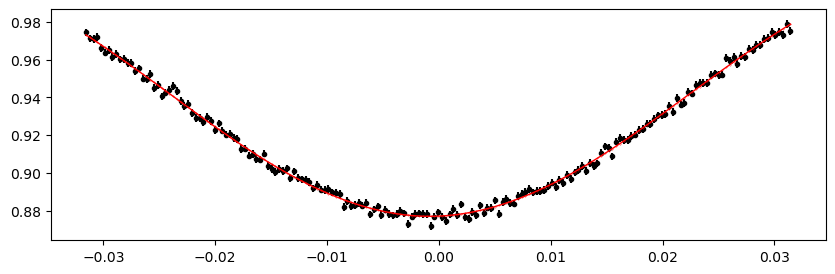

2460488.1104321997 1.0184216004151734 -0.13990038485502054 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 344.06it/s]


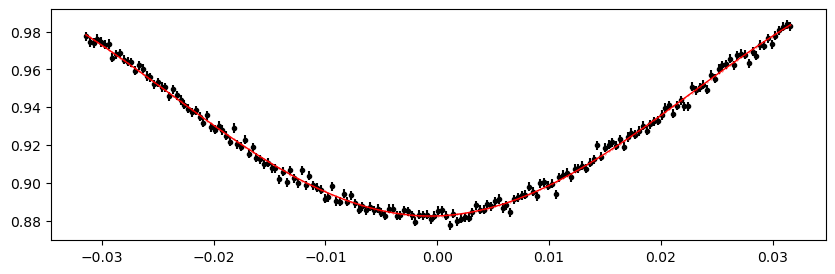

2460492.211303 1.0184216004151734 -0.13990038485502054 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 331.09it/s]


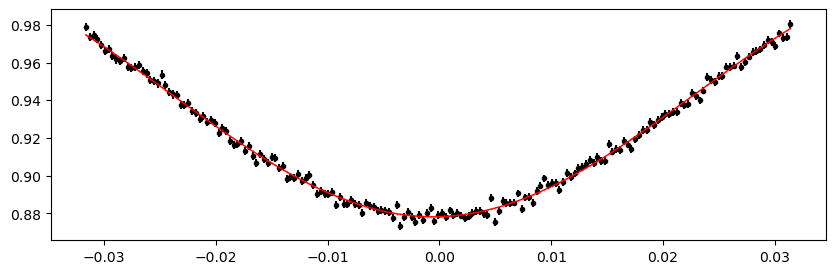

2460496.3121737996 1.0184216004151734 -0.13990038485502054 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 342.83it/s]


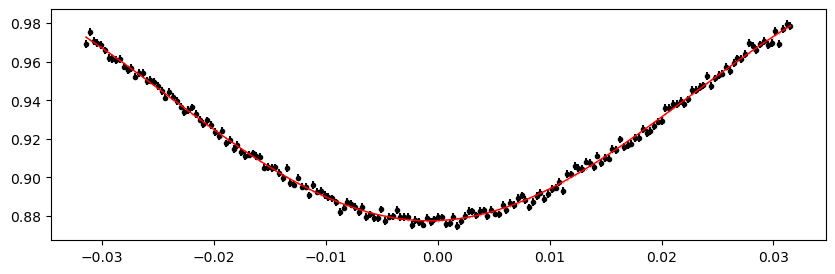

2460500.4130446 1.0184216004151734 -0.13990038485502054 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 344.43it/s]


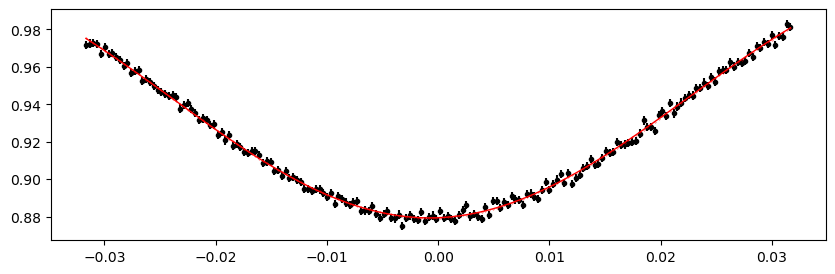

2460504.5139154 1.0184216004151734 -0.13990038485502054 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 344.08it/s]


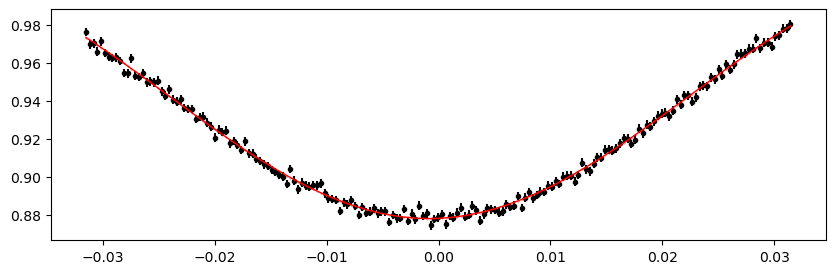

2460508.6147861998 1.0184216004151734 -0.13990038485502054 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 346.32it/s]


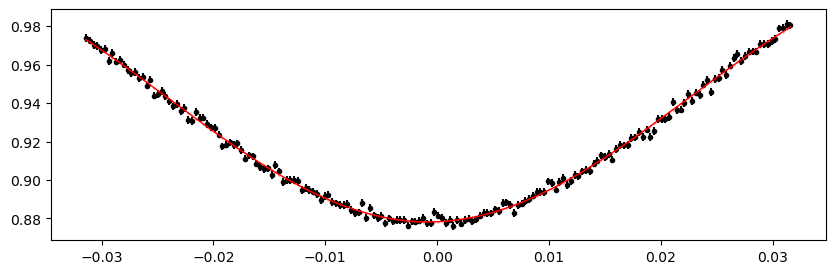

2460512.715657 1.0184216004151734 -0.13990038485502054 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 267.56it/s]


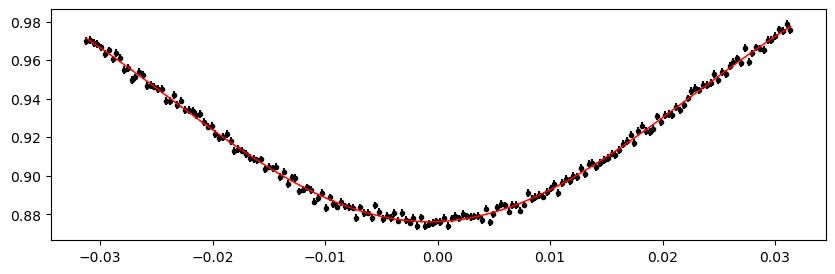

2460516.8165277997 1.0184216004151734 -0.13990038485502054 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 335.34it/s]


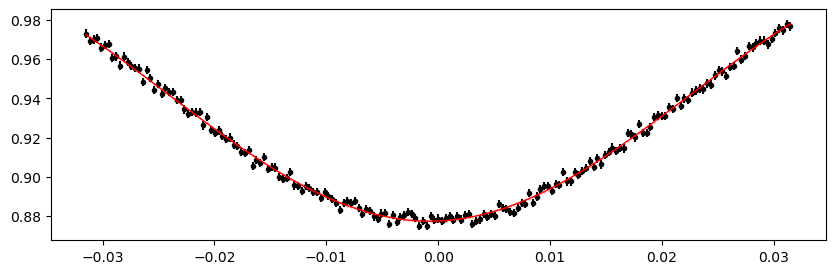

2460520.9173986 1.0184216004151734 -0.13990038485502054 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 336.14it/s]


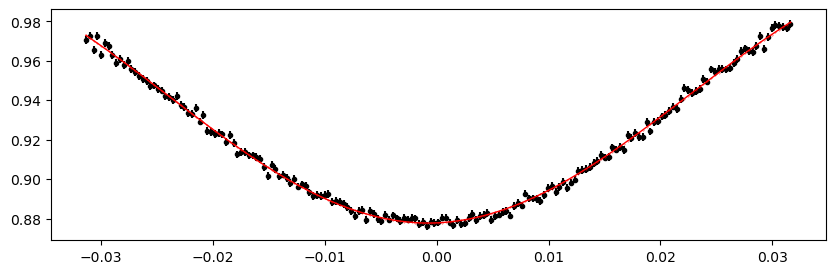

2460525.0182693996 1.0184216004151734 -0.13990038485502054 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 331.35it/s]


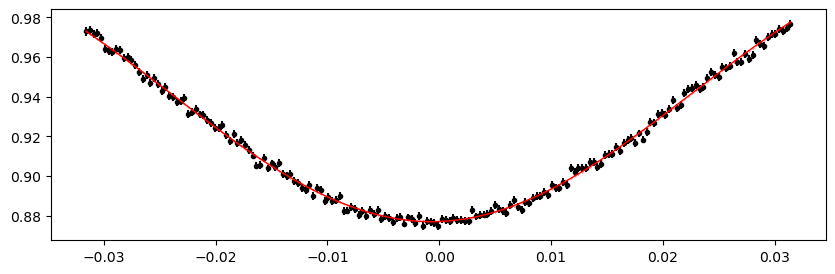

2460529.1191402 1.0184216004151734 -0.13990038485502054 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 337.35it/s]


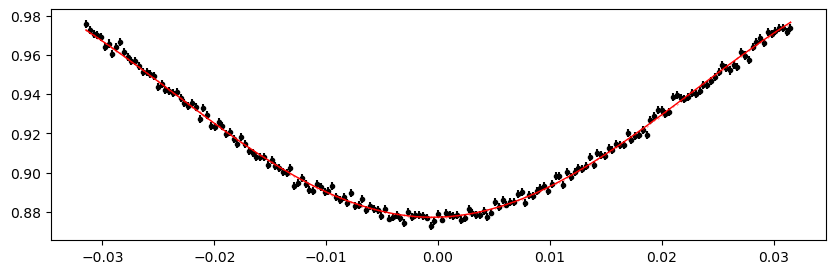

Error while loading conda entry point: conda-libmamba-solver (cannot import name 'Spinner' from 'conda.common.io' (C:\pkg\_winNonPortables\miniforge3\lib\site-packages\conda\common\io.py))
Error while loading conda entry point: conda-libmamba-solver (cannot import name 'Spinner' from 'conda.common.io' (C:\pkg\_winNonPortables\miniforge3\lib\site-packages\conda\common\io.py))
Error while loading conda entry point: conda-libmamba-solver (cannot import name 'Spinner' from 'conda.common.io' (C:\pkg\_winNonPortables\miniforge3\lib\site-packages\conda\common\io.py))
Error while loading conda entry point: conda-libmamba-solver (cannot import name 'Spinner' from 'conda.common.io' (C:\pkg\_winNonPortables\miniforge3\lib\site-packages\conda\common\io.py))


In [47]:
%matplotlib inline

# from importlib import reload
# reload(etv_functions)

print("Fitting individual primary eclipses...")
etv_functions.fit_each_eclipse(data_primary, n_transits, t0_primary, period, mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau, outfile_path,
                               min_number_data=60, # long eclipse duration, I could be more selective on min num. data points
                              )
!$NOTIFY_CMD "Individual primary eclipses fit done"


Fitting individual secondary eclipses...
Existing manifest file found, will skip previously processed LCs and append to end of manifest file
Number 1 has already been completed -- skip
2458689.8785864 1.0134706112551553 -0.1173880084138679 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 338.91it/s]


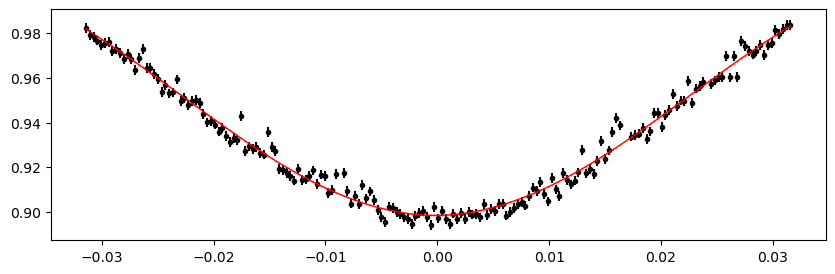

2458693.9794572 1.0134706112551553 -0.1173880084138679 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 336.98it/s]


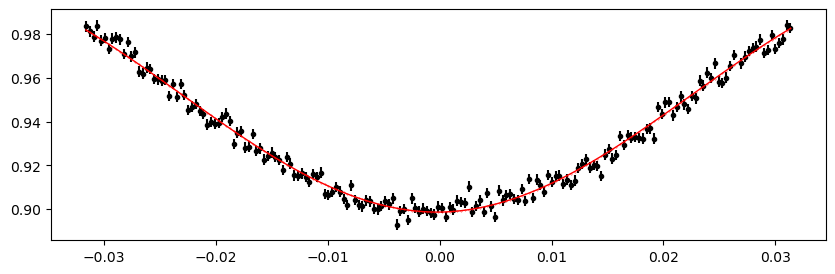

2458698.080328 1.0134706112551553 -0.1173880084138679 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 337.61it/s]


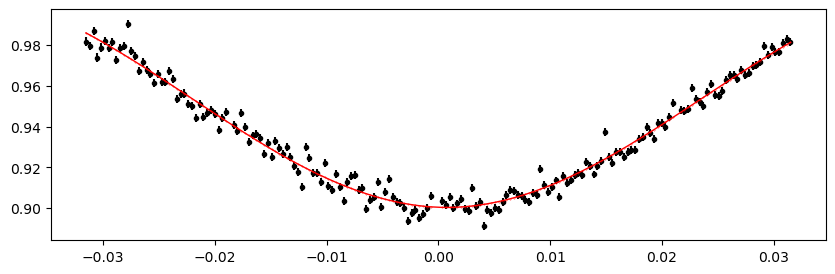

2458702.1811988 1.0134706112551553 -0.1173880084138679 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 337.54it/s]


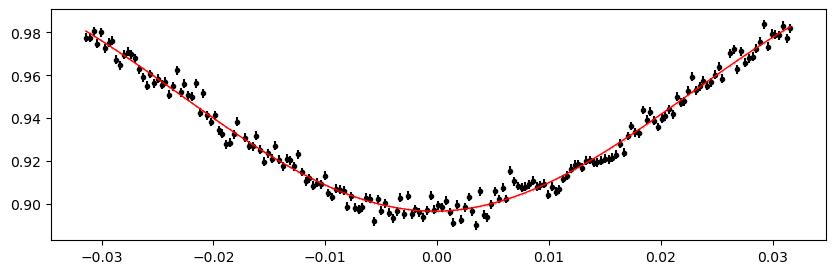

2458706.2820695997 1.0134706112551553 -0.1173880084138679 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 335.80it/s]


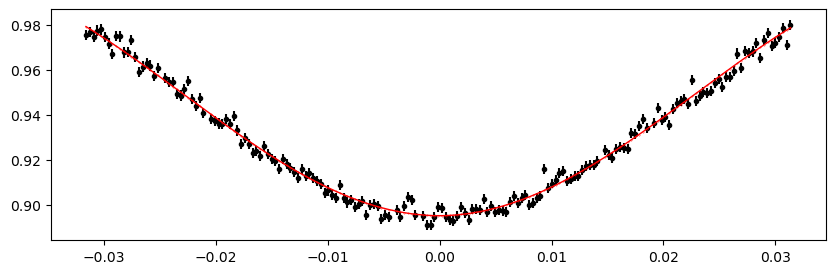

2459391.1274932 1.0134706112551553 -0.1173880084138679 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 336.02it/s]


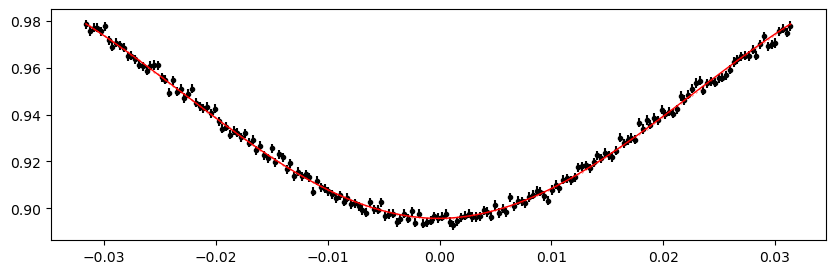

2459395.228364 1.0134706112551553 -0.1173880084138679 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 334.50it/s]


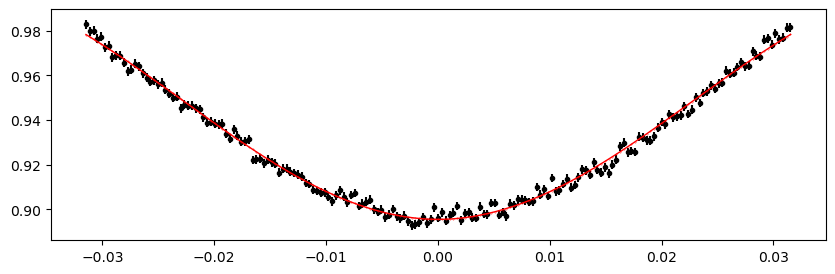

2459399.3292348 1.0134706112551553 -0.1173880084138679 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 334.45it/s]


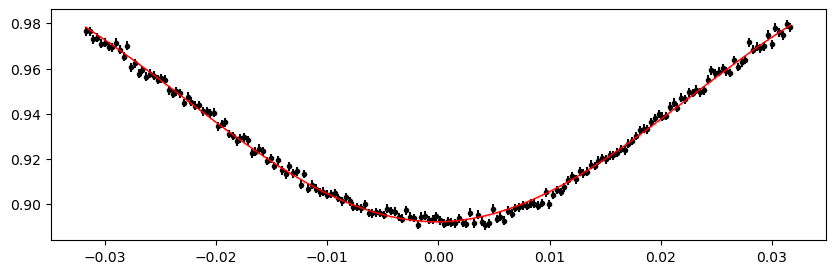

2459403.4301056 1.0134706112551553 -0.1173880084138679 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 333.98it/s]


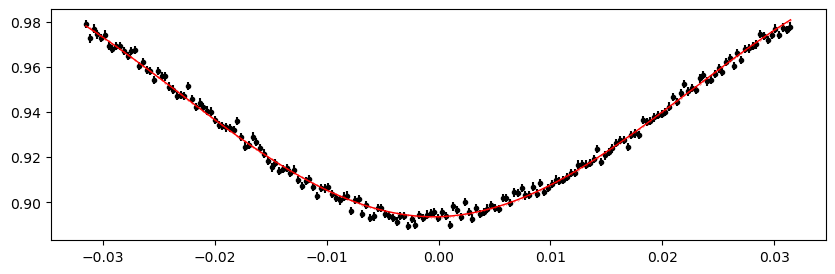

2459407.5309764 1.0134706112551553 -0.1173880084138679 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 334.50it/s]


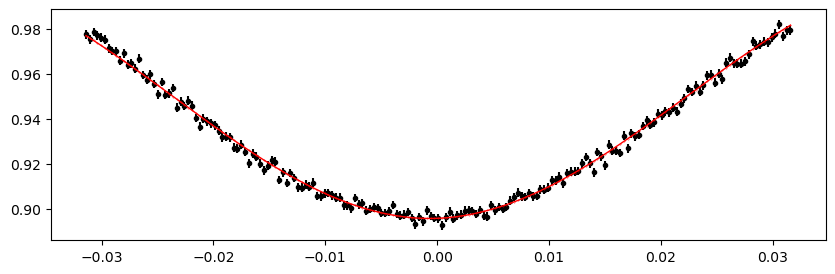

2459411.6318472 1.0134706112551553 -0.1173880084138679 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 337.04it/s]


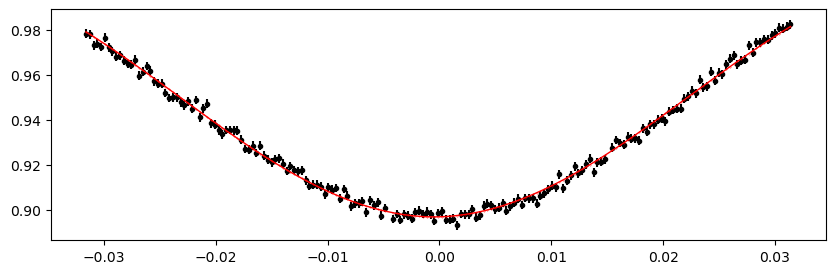

2459415.7327179997 1.0134706112551553 -0.1173880084138679 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 335.21it/s]


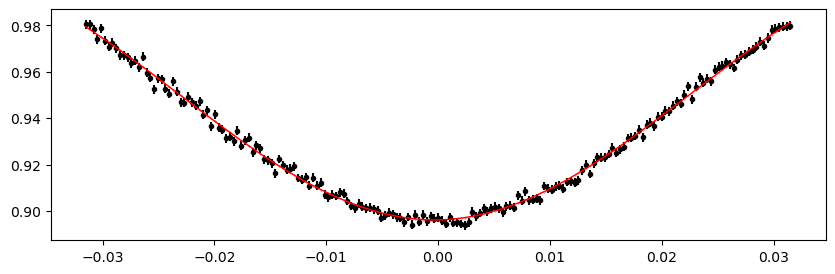

2459423.9344595997 1.0134706112551553 -0.1173880084138679 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 334.23it/s]


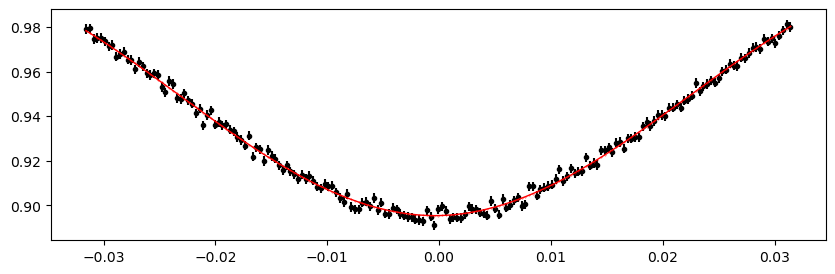

2459428.0353304 1.0134706112551553 -0.1173880084138679 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 336.32it/s]


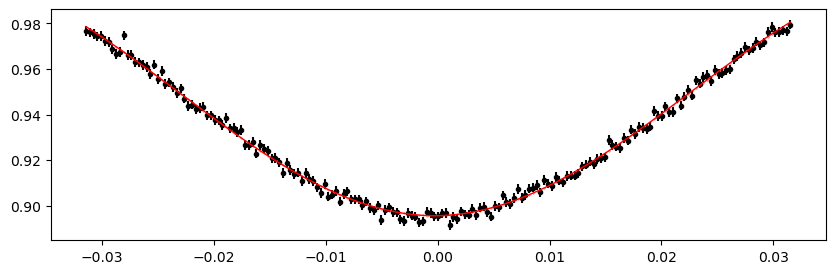

2459432.1362012 1.0134706112551553 -0.1173880084138679 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 337.27it/s]


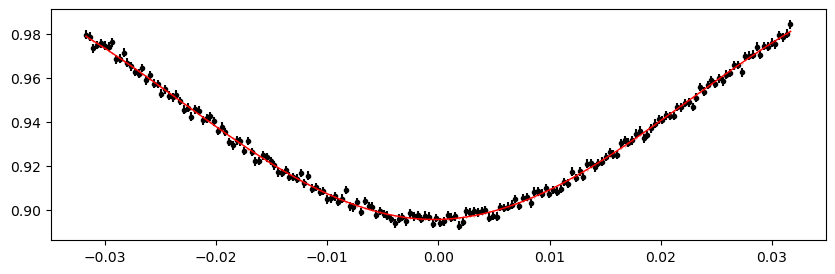

2459436.237072 1.0134706112551553 -0.1173880084138679 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 334.48it/s]


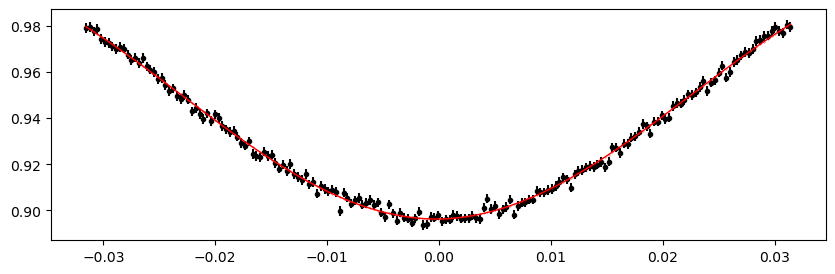

2459440.3379428 1.0134706112551553 -0.1173880084138679 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 334.66it/s]


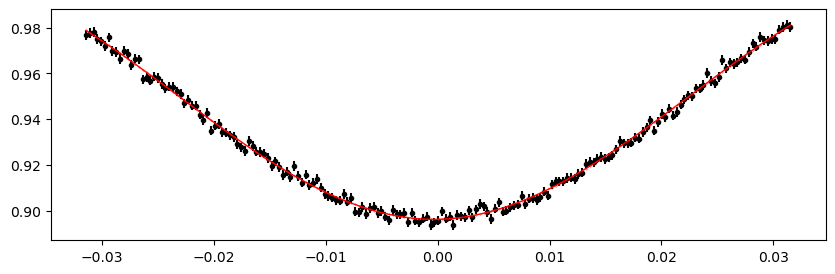

2459444.4388135998 1.0134706112551553 -0.1173880084138679 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 335.24it/s]


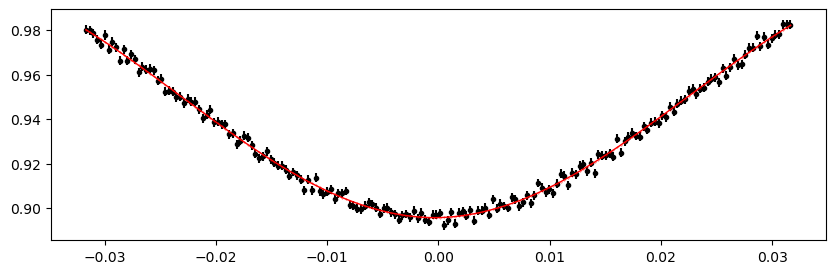

2459747.9032528 1.0134706112551553 -0.1173880084138679 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 330.98it/s]


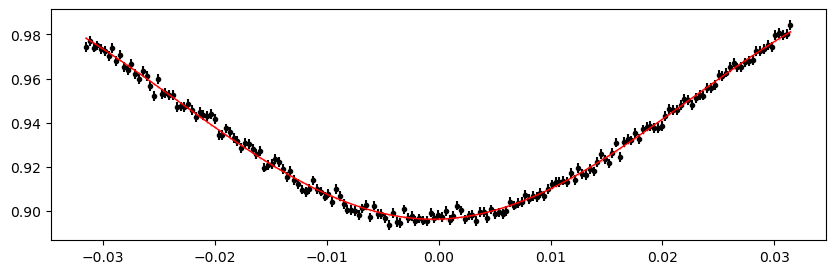

2459752.0041235997 1.0134706112551553 -0.1173880084138679 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 335.80it/s]


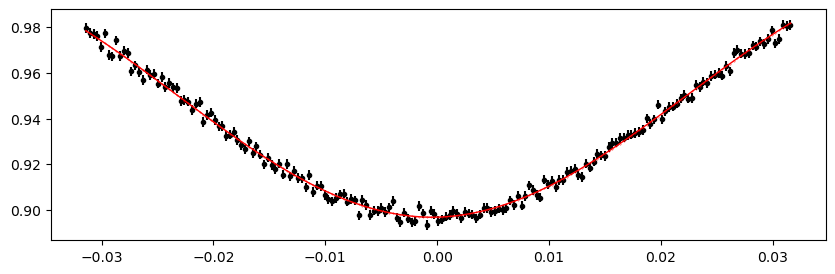

Time 2459756.1049944 does not have enough data points: 17
2459760.2058651997 1.0134706112551553 -0.1173880084138679 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 333.06it/s]


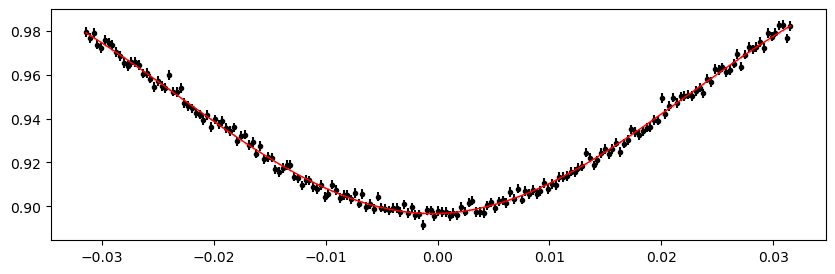

2459764.306736 1.0134706112551553 -0.1173880084138679 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 336.02it/s]


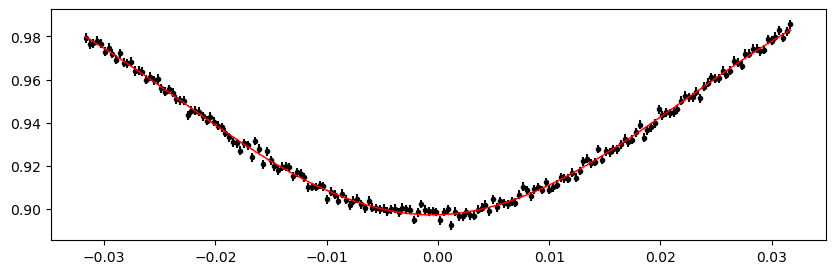

2459768.4076068 1.0134706112551553 -0.1173880084138679 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 337.92it/s]


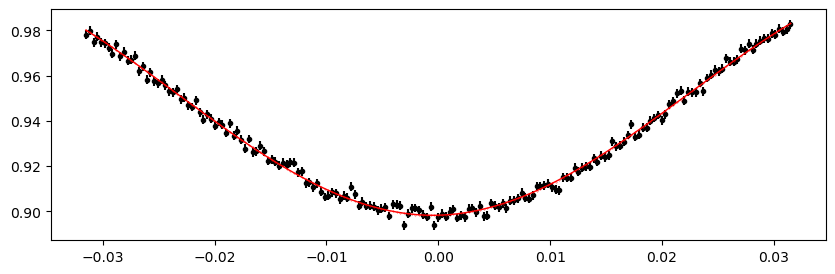

2459772.5084776 1.0134706112551553 -0.1173880084138679 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 340.69it/s]


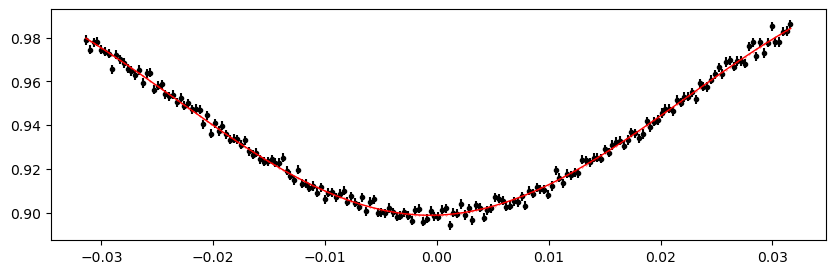

2459776.6093484 1.0134706112551553 -0.1173880084138679 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 342.50it/s]


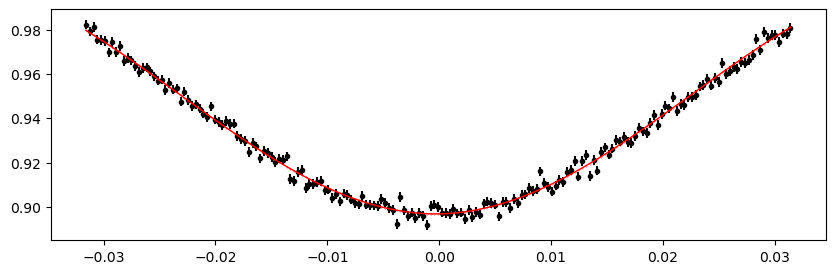

2459780.7102192 1.0134706112551553 -0.1173880084138679 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 343.03it/s]


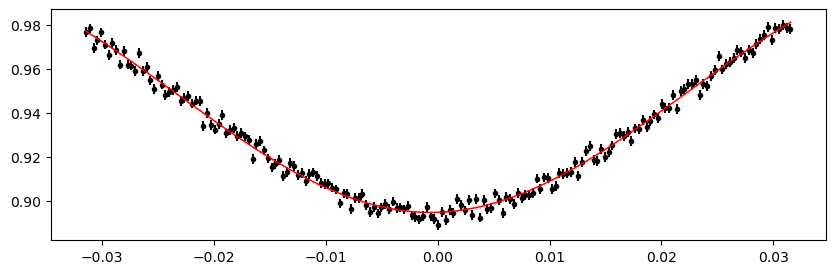

2459784.81109 1.0134706112551553 -0.1173880084138679 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 341.77it/s]


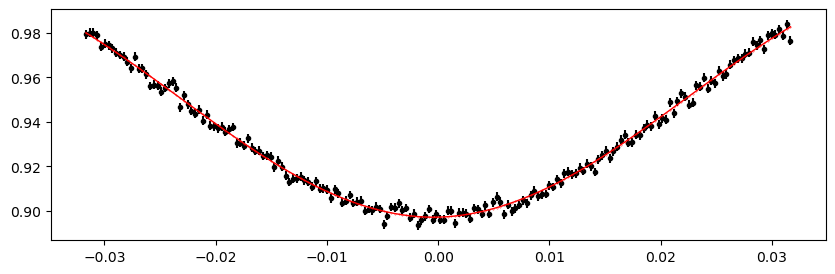

2459788.9119607997 1.0134706112551553 -0.1173880084138679 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 334.49it/s]


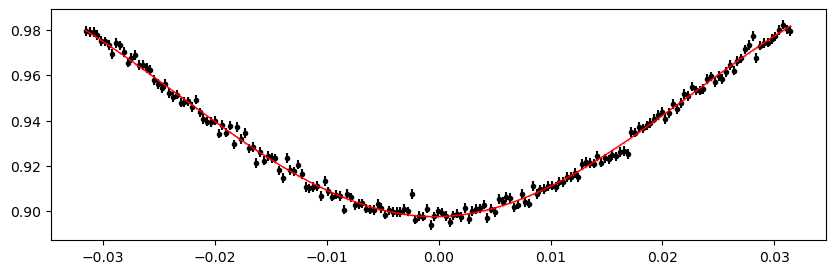

2459793.0128316 1.0134706112551553 -0.1173880084138679 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 334.04it/s]


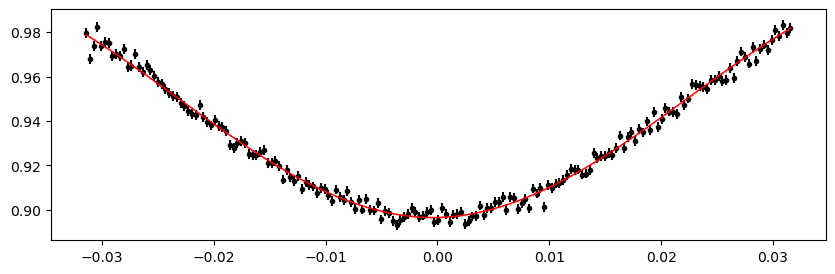

2460313.8234232 1.0134706112551553 -0.1173880084138679 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 366.20it/s]


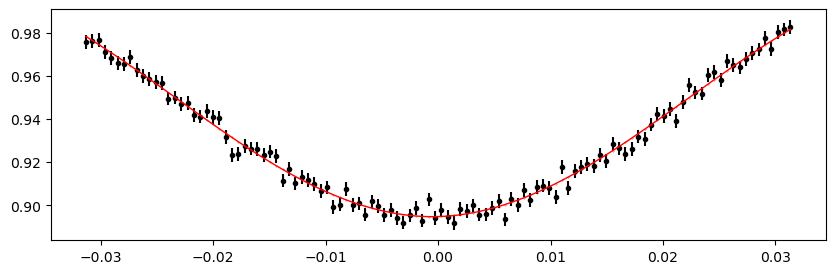

2460317.924294 1.0134706112551553 -0.1173880084138679 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 363.17it/s]


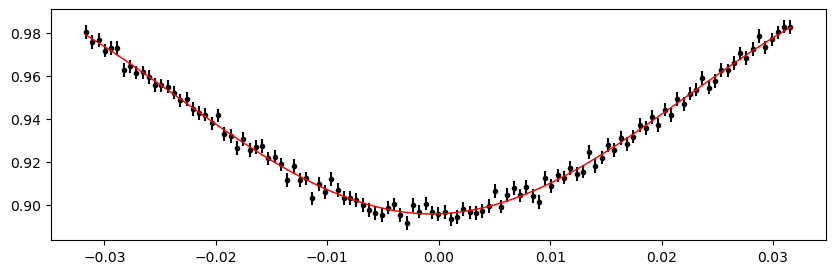

2460322.0251647998 1.0134706112551553 -0.1173880084138679 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 358.68it/s]


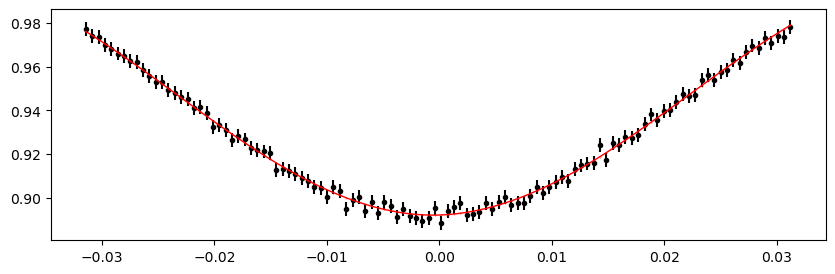

2460326.1260356 1.0134706112551553 -0.1173880084138679 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 376.11it/s]


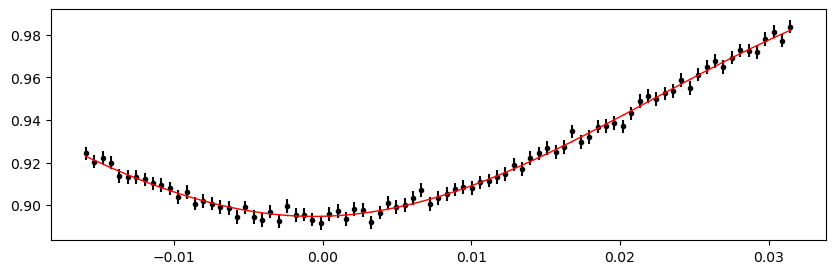

2460330.2269063997 1.0134706112551553 -0.1173880084138679 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 366.71it/s]


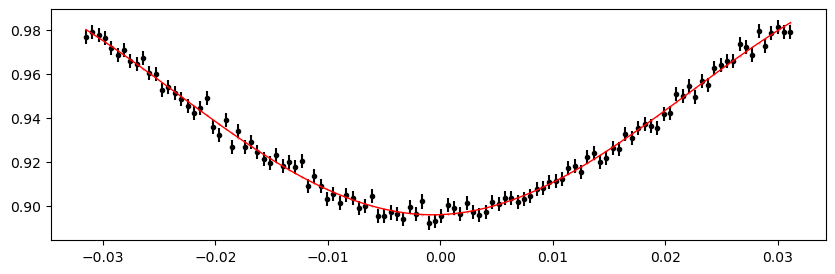

2460334.3277772 1.0134706112551553 -0.1173880084138679 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 363.41it/s]


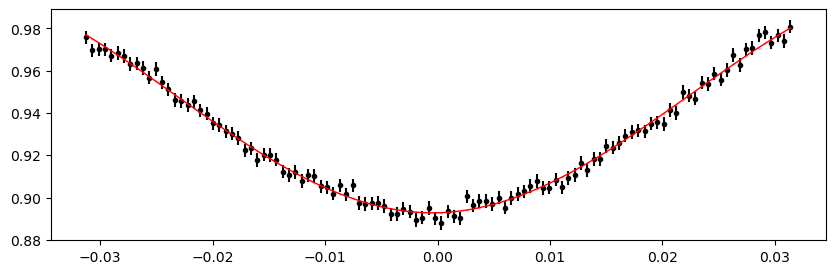

2460338.428648 1.0134706112551553 -0.1173880084138679 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 364.86it/s]


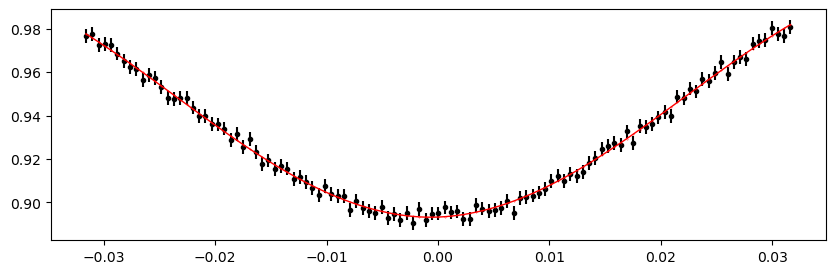

2460481.959126 1.0134706112551553 -0.1173880084138679 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 331.13it/s]


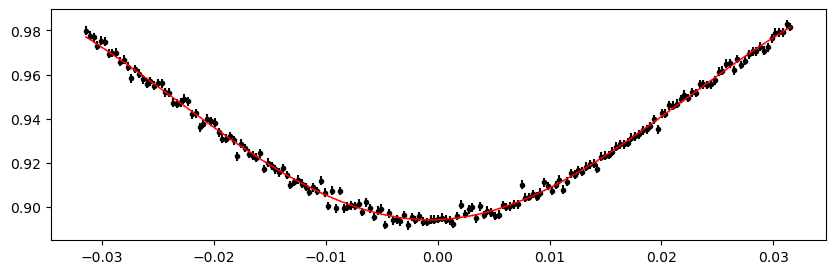

2460486.0599968 1.0134706112551553 -0.1173880084138679 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 334.37it/s]


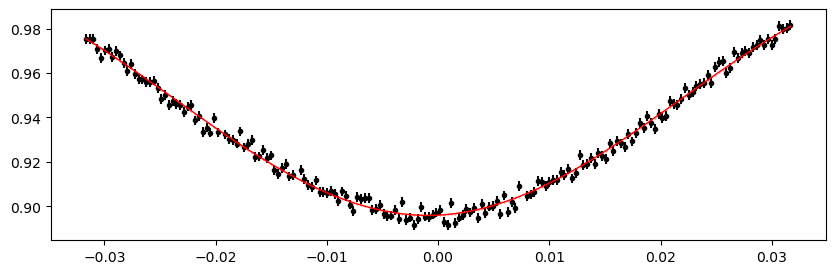

2460490.1608676 1.0134706112551553 -0.1173880084138679 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 336.08it/s]


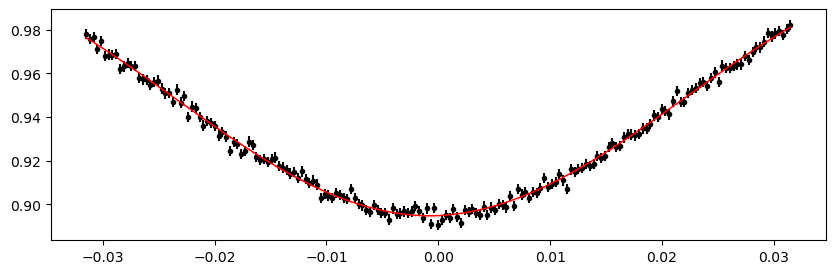

2460494.2617384 1.0134706112551553 -0.1173880084138679 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 332.12it/s]


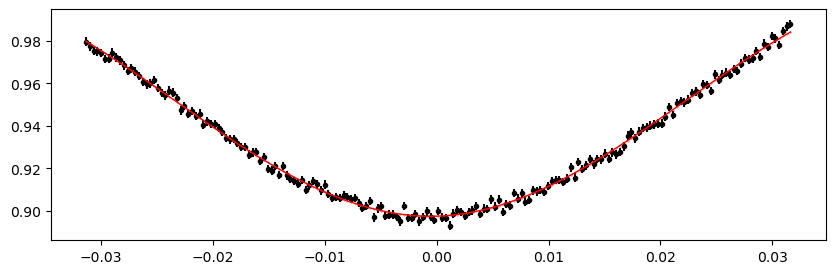

2460498.3626091997 1.0134706112551553 -0.1173880084138679 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 334.34it/s]


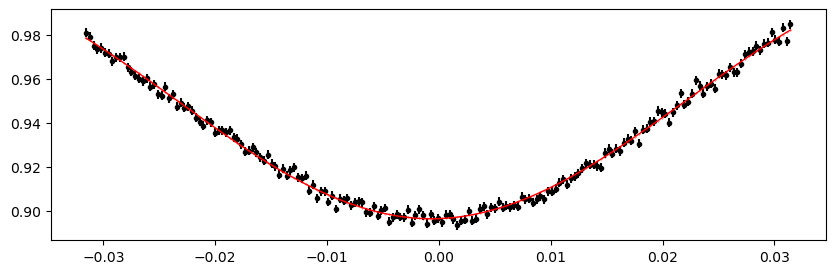

2460502.46348 1.0134706112551553 -0.1173880084138679 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 333.01it/s]


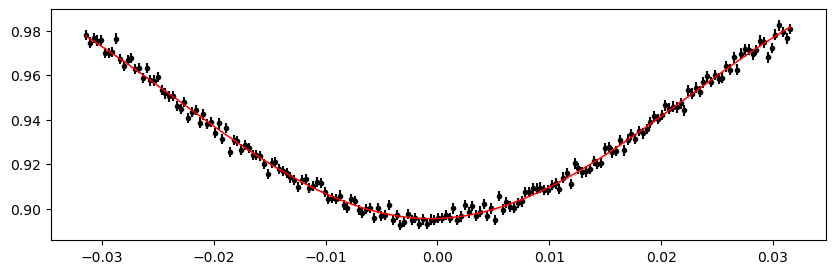

2460506.5643508 1.0134706112551553 -0.1173880084138679 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 370.51it/s]


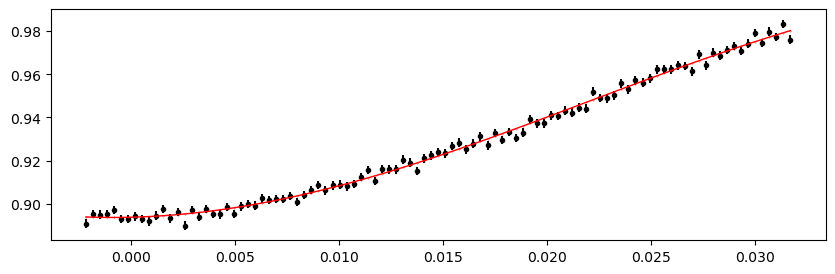

2460510.6652216 1.0134706112551553 -0.1173880084138679 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 323.01it/s]


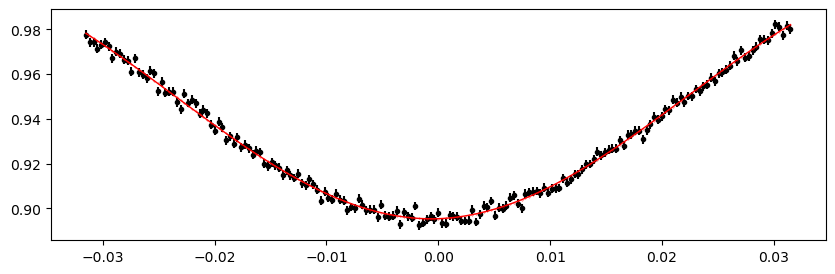

2460514.7660924 1.0134706112551553 -0.1173880084138679 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 331.10it/s]


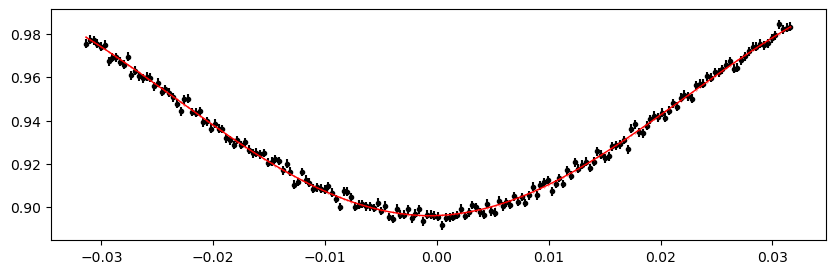

Time 2460518.8669632 does not have enough data points: 18
2460522.967834 1.0134706112551553 -0.1173880084138679 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 345.94it/s]


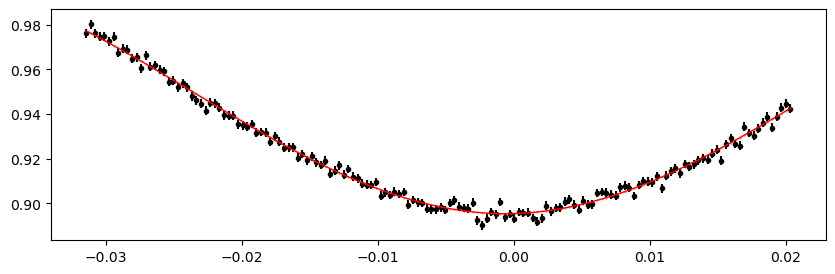

2460527.0687047997 1.0134706112551553 -0.1173880084138679 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 367.47it/s]


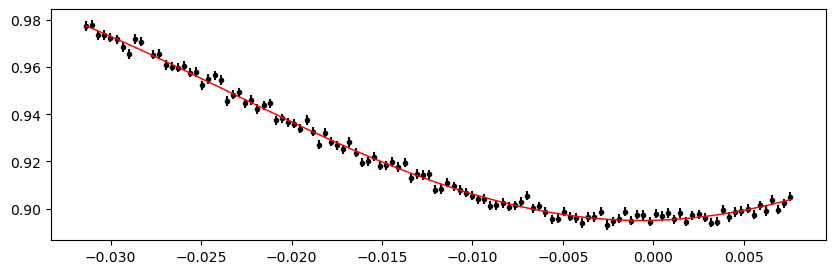

2460531.1695756 1.0134706112551553 -0.1173880084138679 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 380.89it/s]


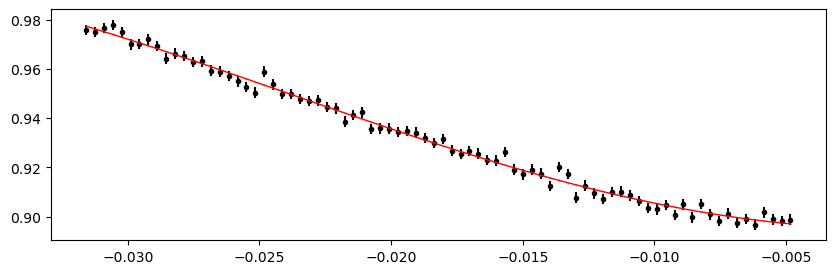

Error while loading conda entry point: conda-libmamba-solver (cannot import name 'Spinner' from 'conda.common.io' (C:\pkg\_winNonPortables\miniforge3\lib\site-packages\conda\common\io.py))
Error while loading conda entry point: conda-libmamba-solver (cannot import name 'Spinner' from 'conda.common.io' (C:\pkg\_winNonPortables\miniforge3\lib\site-packages\conda\common\io.py))
Error while loading conda entry point: conda-libmamba-solver (cannot import name 'Spinner' from 'conda.common.io' (C:\pkg\_winNonPortables\miniforge3\lib\site-packages\conda\common\io.py))
Error while loading conda entry point: conda-libmamba-solver (cannot import name 'Spinner' from 'conda.common.io' (C:\pkg\_winNonPortables\miniforge3\lib\site-packages\conda\common\io.py))


In [51]:
# ---

%matplotlib inline

if t0_secondary is not None:
    print("Fitting individual secondary eclipses...")
    etv_functions.fit_each_eclipse(data_secondary, n_transits, t0_secondary, period, mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s, outfile_path_s,
                                   min_number_data=60,  # long eclipse duration, I could be more selective on min num. data points
                                  )
    !$NOTIFY_CMD "Individual secondary eclipses fit done"
else:
    print("No secondary eclipses defined. No-Op.")

## ETV O-C plot

In [52]:
def get_time_span_isodate(df):
    start, end = df.iloc[0]['midpoint'], df.iloc[-1]['midpoint']
    start = Time(start, format="jd").to_value("iso", subfmt="date")
    end = Time (end,format="jd").to_value("iso", subfmt="date")
    return f"{start} - {end}"

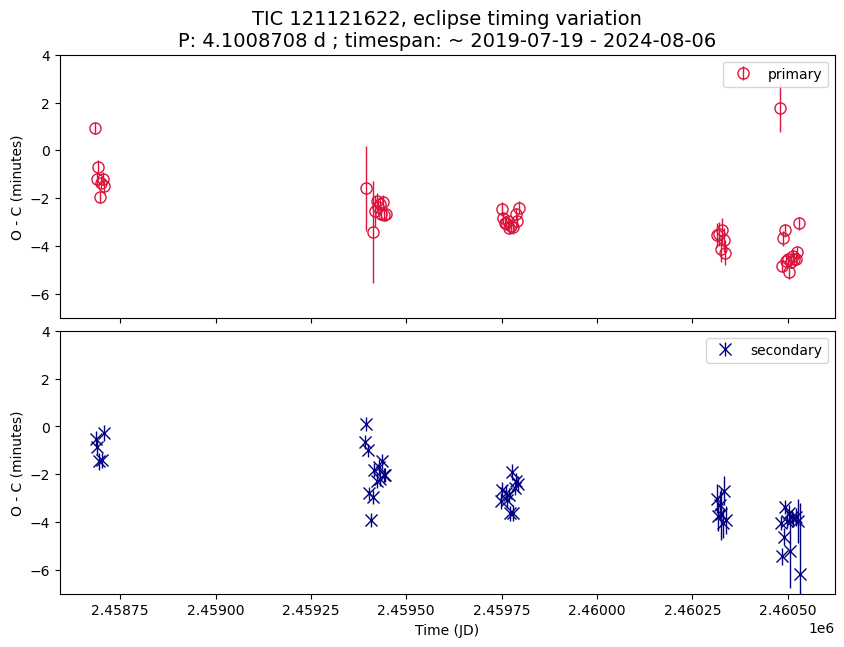

In [53]:
%matplotlib inline
# %matplotlib widget


title_suffix = "eclipse timing variation"

#plot the extracted transit times to check for ETVs

num_rows = 2 if t0_secondary is not None else 1
figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5
# num_rows = 1  # force to plot primary only
# figsize_y = 3.3

fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
    axs = [axs]

in_df_primary = pd.read_csv(outfile_path)
in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
in_df_primary['std_mins'] = in_df_primary['stdv_t0']*period*24*60
in_df_primary_all = in_df_primary  # in case filtering is helpful

# in_df_primary = in_df_primary[in_df_primary.std_mins < 10]  # filter out outliers in error
# print(f"Note: {len(in_df_primary_all) - len(in_df_primary)} data points in df_primary filtered out due to huge O-C error.")

# axs[0].plot(in_df_primary['epoch'], in_df_primary['shift_mins'],
#              lw = 1, color = 'crimson', )
# axs[0].scatter(in_df_primary['epoch'], in_df_primary['shift_mins'],
#              marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
axs[0].errorbar(in_df_primary['epoch'], in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'],
             lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")

# if False:
if t0_secondary is not None:
    in_df_secondary = pd.read_csv(outfile_path_s)
    in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period)
    in_df_secondary['shift_mins'] = in_df_secondary['t0']*period*24*60
    in_df_secondary['std_mins'] = in_df_secondary['stdv_t0']*period*24*60
    in_df_secondary_all = in_df_secondary  # in case filtering is helpful

    # in_df_secondary = in_df_secondary[in_df_secondary.std_mins < 10]  # filter out outliers in error
    # print(f"Note: {len(in_df_secondary_all) - len(in_df_secondary)} data points in in_df_secondary filtered out due to huge O-C error.")

    # axs[1].plot(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
    #              lw = 1, color = 'navy', )
    # axs[1].scatter(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
    #              marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
    axs[1].errorbar(in_df_secondary['epoch'], in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'],
                 lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );
else:
    in_df_secondary = None

for ax in axs:
    ax.set_ylabel("O - C (minutes)")
    ax.legend();

axs[-1].set_xlabel(f"Time ({search_result.time.format.upper()})")
axs[0].set_title(f"TIC {ticid}, {title_suffix}\nP: {period} d ; timespan: ~ {get_time_span_isodate(in_df_primary)}", fontsize=14)

plt.subplots_adjust(hspace=0.05)
[ax.set_ylim(-7, 4) for ax in axs]  # use a consistent y-scale for both Kepler (not shown) and TESS data 
plt.show()

In [ ]:
# # to help to filter out valeus with huge error
# ax = in_df_primary_all.std_mins.hist(bins=100)
# ax.set_xscale("log")
# ax.set_yscale("log")
# plt.show()

# ax = in_df_secondary_all.std_mins.hist(bins=100)
# ax.set_xscale("log")
# ax.set_yscale("log")
# plt.show()

### O-C Plot, Zoom In

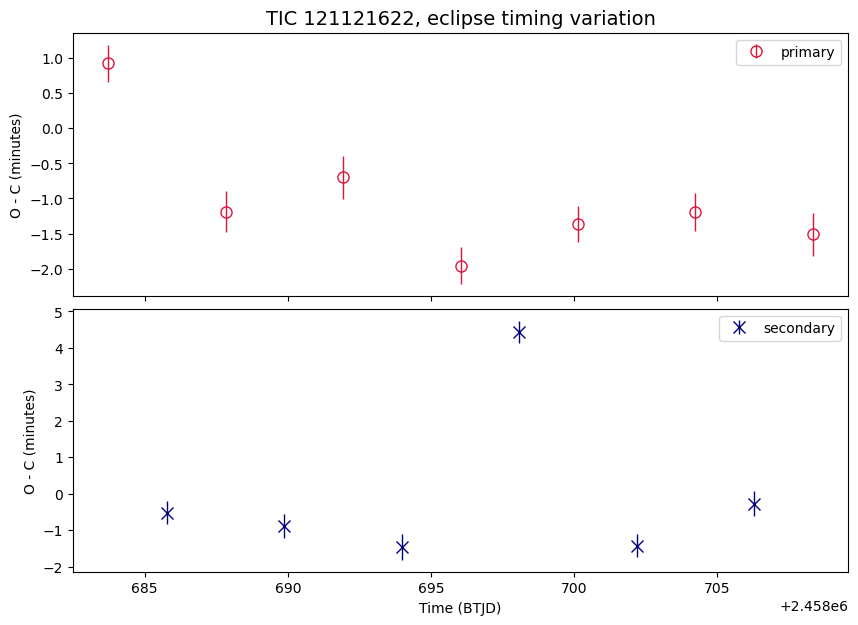

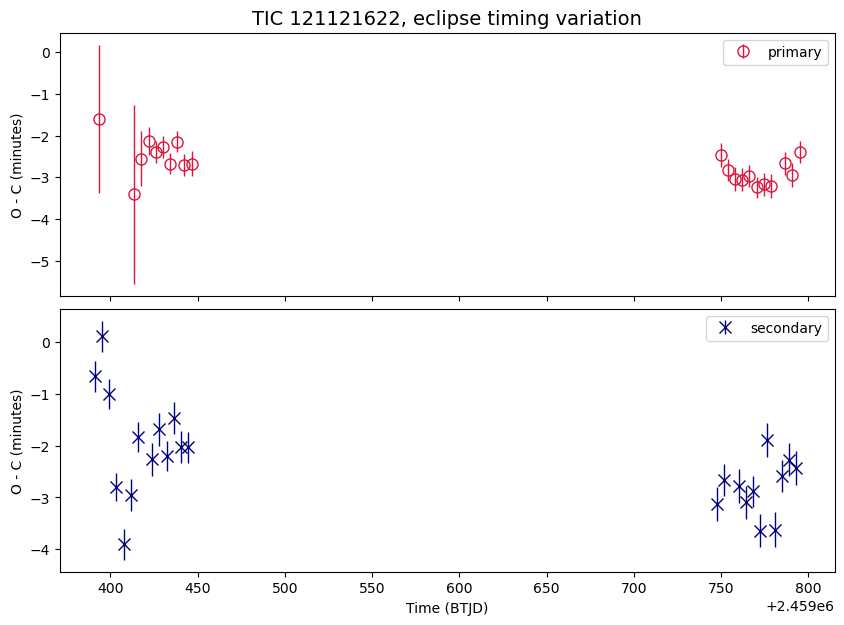

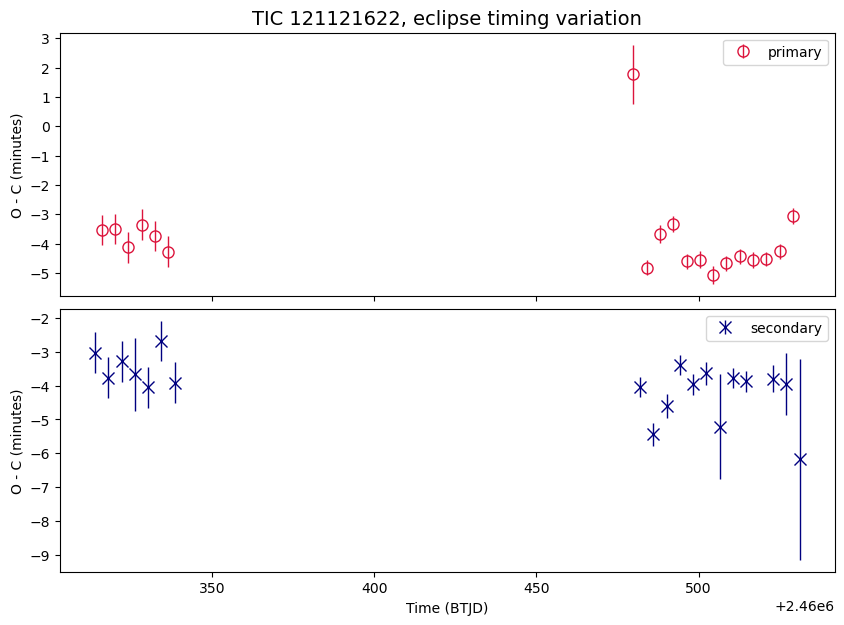

In [56]:
%matplotlib inline
# %matplotlib widget

zoom_ranges = [
    (1600, 1800),  # in BTJD here, the data is in JD
    (2350, 2900),
    (3250, 3700),
]

def tweak_axs_list(axs_list):
    # axs_list[0][1].set_ylim(-20, 30);
    # axs_list[1][0].set_ylim(None, 0.5);
    # axs_list[1][1].set_ylim(-5.5, 2);

    # ax = axs_list[0][0]
    # ax.set_title(f"{ax.get_title()} (2min cadence)")
    # ax = axs_list[1][0]
    # ax.set_title(f"{ax.get_title()} (2min cadence)")

    pass


def plot_oc_in_zoom_ranges(in_df_primary, in_df_secondary, zoom_ranges):
    axs_list = []
    for zoom_start, zoom_end in zoom_ranges:
        zoom_start = Time(zoom_start, format="btjd").to_value("jd")
        zoom_end = Time(zoom_end, format="btjd").to_value("jd")
        
        num_rows = 2 if t0_secondary is not None else 1
        figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5

        fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
        if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
            axs = [axs]

        df_zoom = in_df_primary[(in_df_primary['epoch'] > zoom_start) & (in_df_primary['epoch'] < zoom_end)]

        # axs[0].scatter(df_zoom['epoch'], df_zoom['shift_mins'],
        #                marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
        axs[0].errorbar(df_zoom['epoch'], df_zoom['shift_mins'], yerr = df_zoom['std_mins'],
                        lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")

        if in_df_secondary is not None:
            df_zoom = in_df_secondary[(in_df_secondary['epoch'] > zoom_start) & (in_df_secondary['epoch'] < zoom_end)]

            # axs[1].scatter(df_zoom['epoch'], df_zoom['shift_mins'],
            #                marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
            axs[1].errorbar(df_zoom['epoch'], df_zoom['shift_mins'], yerr = df_zoom['std_mins'],
                            lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );

        for ax in axs:
            ax.set_ylabel("O - C (minutes)")
            ax.legend();

        axs[-1].set_xlabel("Time (BTJD)")
        axs[0].set_title(f"TIC {ticid}, {title_suffix}", fontsize=14)

        plt.subplots_adjust(hspace=0.05)
        axs_list.append(axs)
    return axs_list


axs_list = plot_oc_in_zoom_ranges(in_df_primary, in_df_secondary, zoom_ranges)
tweak_axs_list(axs_list);

## make a periodogram 

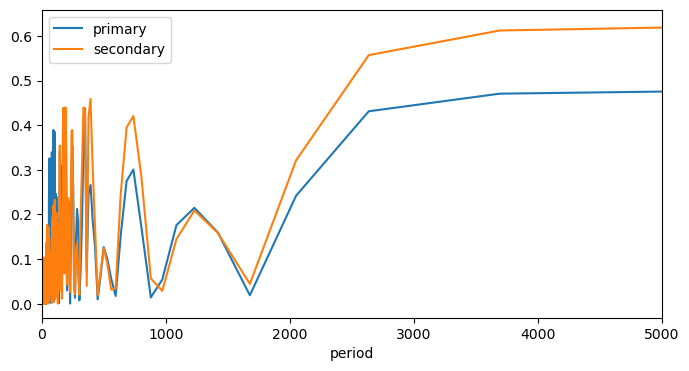

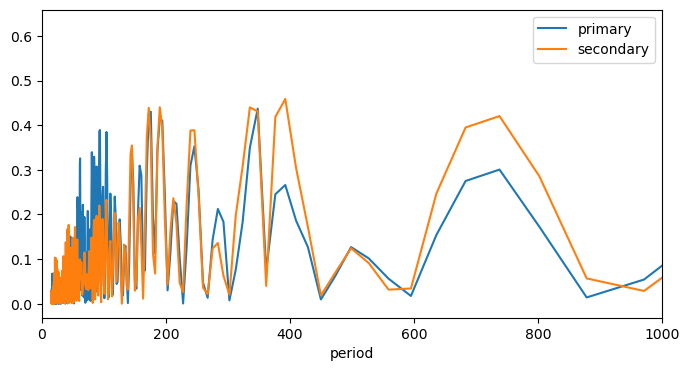

In [57]:
frequency, power = LombScargle(in_df_primary['epoch'], in_df_primary['shift_mins']).autopower()

fig, ax = plt.subplots(figsize=(8, 4))

plt.plot(1/frequency, power, label = 'primary')

if t0_secondary is not None:
    frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower()
    plt.plot(1/frequency_s, power_s, label = 'secondary')

plt.xlabel("period")

plt.legend()
plt.xlim(0, 5000)
plt.show()


if True:
    fig, ax = plt.subplots(figsize=(8, 4))

    plt.plot(1/frequency, power, label = 'primary')

    if t0_secondary is not None:
        plt.plot(1/frequency_s, power_s, label = 'secondary')

    plt.xlabel("period")

    plt.legend()
    plt.xlim(0, 1000)
    plt.show()

## O-C plot, folded

- for periodic trend in O-C

In [58]:
def truncate_freq_power_to_period_range(freq, power, period_min, period_max):
    f, p = freq, power
    if period_min is not None:
        f, p = f[f < 1 / period_min], p[f < 1 / period_min]
    if period_max is not None:
        f, p = f[f > 1 / period_max], p[f >  1 / period_max]
    return f, p


def plot_oc_folded(period_min=None, period_max=None, period_min_s=None, period_max_s=None, period=None, period_s=None):

    if period is None:
        _f, _p = truncate_freq_power_to_period_range(frequency, power, period_min, period_max)
        period = 1 / _f[np.argmax(_p)]
    phase_oc = etv_functions.phase_data(in_df_primary.epoch, 0, period)

    fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y * 1.1), sharex=False)
    if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
        axs = [axs]
    
    axs[0].scatter(phase_oc, in_df_primary.shift_mins, marker = 'o', s=12**2, c=in_df_primary.epoch);
    axs[0].errorbar(phase_oc, in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'],
                    lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'None', label="primary")
    axs[0].set_title(f"TIC {ticid}, {title_suffix}\nfolded with P={period:.4f} d", fontsize=14)

    if in_df_secondary is not None:
        if period_s is None:
            _f, _p = truncate_freq_power_to_period_range(frequency_s, power_s, period_min_s, period_max_s)
            period_s= 1 / _f[np.argmax(_p)]
        phase_oc_s = etv_functions.phase_data(in_df_secondary.epoch, 0, period_s)
        axs[1].scatter(phase_oc_s, in_df_secondary.shift_mins, marker = 'o',  s=12**2, c=in_df_secondary.epoch);
        axs[1].errorbar(phase_oc_s, in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'],
                        lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color='None', ecolor='navy', markeredgecolor = 'None', label="secondary" );
        axs[1].set_title(f"TIC {ticid}, {title_suffix}\nfolded with P={period_s:.4f} d", fontsize=14)

    for ax in axs:
        ax.set_ylabel("O - C (minutes)")
        ax.set_xlabel("Phase (Normalized)")
        ax.legend();
    plt.subplots_adjust(hspace=0.4)
    return axs

In [59]:
%matplotlib inline
# %matplotlib widget

if False:  # plot O-C periodic trend by folding with a period (from LS Periodogram by default)
    def tweak_axs(axs):
        pass

    axs = plot_oc_folded(
        period_min=None, period_max=None,
        period_min_s=None, period_max_s=None
    )
    tweak_axs(axs)

## Results Summary

In [60]:
# FILL-IN the ETV results / comments
has_etv = "?"
comments = "O-C suggests linear change, but unsure if it's jsut inaccuracy in the period, or that there is very long-term non-linear change (not evient in TESS) - because the epoch / period used is from Kepler EB about 10 years before the TESS data. Yet the O-C at the beginning of TESs data is close to 0 (it should be a larger negative number)."

# Eclipse depth from the model
depth_pct_p = round(-mean_alpha1 * 100, 2)
if t0_secondary is not None:
    depth_pct_s = round(-mean_alpha1_s * 100, 2)
else:
    depth_pct_s = None

summary = {
    "tic": ticid,
    "has_etv": has_etv,
    "comments": comments,
    "period": period,  # the period used in ETV analysis
    "depth_pct_p": depth_pct_p,
    "depth_pct_s": depth_pct_s,
    "epoch_p": t0_primary,
    "epoch_s": t0_secondary,
    "num_sectors": len(sr),
    "time_span": round(time[-1] - time[0], 2),
    "time_start": round(time[0], 2),
    "time_end": round(time[-1], 2),
}

summary = pd.DataFrame.from_dict(summary, orient="index")
with pd.option_context('display.max_colwidth', None, 'display.max_rows', 999, 'display.max_columns', 99):
    display(summary);

# Single line to be added to a CSV
print("")
print(summary.transpose().to_csv(
    index=False,
    header=True,
))

0
tic                                                                                                                                                                                                                                                                                                                                               121121622
has_etv                                                                                                                                                                                                                                                                                                                                                   ?
comments     O-C suggests linear change, but unsure if it's jsut inaccuracy in the period, or that there is very long-term non-linear change (not evient in TESS) - because the epoch / period used is from Kepler EB about 10 years before the TESS data. Yet the O-C at the beginning of TESs data is close to 0 (it should be a larger negative number).
period                                                                                                                                                                                                                                                                                                                                             4.100871
depth_pct_p                                                                                                                                                                                                                                                                                                                                           13.99
depth_pct_s                                                                                                                                                                                                                                                                                                                                           11.74
epoch_p                                                                                                                                                                                                                                                                                                                                      2458679.626409
epoch_s                                                                                                                                                                                                                                                                                                                                      2458681.676845
num_sectors                                                                                                                                                                                                                                                                                                                                               8
time_span                                                                                                                                                                                                                                                                                                                                           1849.82
time_start                                                                                                                                                                                                                                                                                                                                       2458683.36
time_end                                                                                                                                                                  


tic,has_etv,comments,period,depth_pct_p,depth_pct_s,epoch_p,epoch_s,num_sectors,time_span,time_start,time_end
121121622,?,"O-C suggests linear change, but unsure if it's jsut inaccuracy in the period, or that there is very long-term non-linear change (not evient in TESS) - because the epoch / period used is from Kepler EB about 10 years before the TESS data. Yet the O-C at the beginning of TESs data is close to 0 (it should be a larger negative number).",4.1008708,13.99,11.74,2458679.6264094,2458681.6768448,8,1849.82,2458683.36,2460533.18

